In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import tensorflow as tf
from keras import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import LSTM
from prophet import Prophet

In [2]:
df = pd.read_csv("goldstock.csv")

In [3]:
df

Unnamed: 0        Date   Close    Volume    Open    High     Low
0              0  2024-01-19  2029.3  166078.0  2027.4  2041.9  2022.2
1              1  2024-01-18  2021.6  167013.0  2009.1  2025.6  2007.7
2              2  2024-01-17  2006.5  245194.0  2031.7  2036.1  2004.6
3              3  2024-01-16  2030.2  277995.0  2053.4  2062.8  2027.6
4              4  2024-01-12  2051.6  250946.0  2033.2  2067.3  2033.1
...          ...         ...     ...       ...     ...     ...     ...
2506        2528  2014-01-28  1250.5   81426.0  1254.9  1261.9  1248.0
2507        2529  2014-01-27  1263.5   63419.0  1269.9  1280.1  1252.0
2508        2530  2014-01-24  1264.5   34998.0  1264.3  1273.2  1256.9
2509        2531  2014-01-23  1262.5   41697.0  1235.1  1267.1  1230.8
2510        2532  2014-01-22  1238.6   80262.0  1240.5  1243.5  1235.5

[2511 rows x 7 columns]

In [4]:
df = df.drop('Unnamed: 0', axis=1)

In [5]:
df

Date   Close    Volume    Open    High     Low
0     2024-01-19  2029.3  166078.0  2027.4  2041.9  2022.2
1     2024-01-18  2021.6  167013.0  2009.1  2025.6  2007.7
2     2024-01-17  2006.5  245194.0  2031.7  2036.1  2004.6
3     2024-01-16  2030.2  277995.0  2053.4  2062.8  2027.6
4     2024-01-12  2051.6  250946.0  2033.2  2067.3  2033.1
...          ...     ...       ...     ...     ...     ...
2506  2014-01-28  1250.5   81426.0  1254.9  1261.9  1248.0
2507  2014-01-27  1263.5   63419.0  1269.9  1280.1  1252.0
2508  2014-01-24  1264.5   34998.0  1264.3  1273.2  1256.9
2509  2014-01-23  1262.5   41697.0  1235.1  1267.1  1230.8
2510  2014-01-22  1238.6   80262.0  1240.5  1243.5  1235.5

[2511 rows x 6 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2511 entries, 0 to 2510
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2511 non-null   object 
 1   Close   2511 non-null   float64
 2   Volume  2511 non-null   float64
 3   Open    2511 non-null   float64
 4   High    2511 non-null   float64
 5   Low     2511 non-null   float64
dtypes: float64(5), object(1)
memory usage: 117.8+ KB


In [7]:
df.describe()

Close         Volume         Open         High          Low
count  2511.000000    2511.000000  2511.000000  2511.000000  2511.000000
mean   1498.726085  185970.770609  1498.725528  1508.451454  1488.869932
std     298.824811   97600.769382   299.118187   301.262244   296.417703
min    1049.600000       1.000000  1051.500000  1062.700000  1045.400000
25%    1249.850000  126693.500000  1249.500000  1257.300000  1242.350000
50%    1332.800000  175421.000000  1334.000000  1342.400000  1326.600000
75%    1805.850000  234832.000000  1805.600000  1815.450000  1793.050000
max    2093.100000  787217.000000  2094.400000  2098.200000  2074.600000

In [8]:
df.shape

(2511, 6)

In [9]:
data = df.set_index('Date')
data.index = pd.to_datetime(data.index)
data = data.sort_index()
data

Close    Volume    Open    High     Low
Date                                                
2014-01-22  1238.6   80262.0  1240.5  1243.5  1235.5
2014-01-23  1262.5   41697.0  1235.1  1267.1  1230.8
2014-01-24  1264.5   34998.0  1264.3  1273.2  1256.9
2014-01-27  1263.5   63419.0  1269.9  1280.1  1252.0
2014-01-28  1250.5   81426.0  1254.9  1261.9  1248.0
...            ...       ...     ...     ...     ...
2024-01-12  2051.6  250946.0  2033.2  2067.3  2033.1
2024-01-16  2030.2  277995.0  2053.4  2062.8  2027.6
2024-01-17  2006.5  245194.0  2031.7  2036.1  2004.6
2024-01-18  2021.6  167013.0  2009.1  2025.6  2007.7
2024-01-19  2029.3  166078.0  2027.4  2041.9  2022.2

[2511 rows x 5 columns]

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2511 entries, 2014-01-22 to 2024-01-19
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2511 non-null   float64
 1   Volume  2511 non-null   float64
 2   Open    2511 non-null   float64
 3   High    2511 non-null   float64
 4   Low     2511 non-null   float64
dtypes: float64(5)
memory usage: 117.7 KB


In [11]:
data.index.duplicated().sum()

18

In [12]:
data[data.index.duplicated()]

Close    Volume    Open    High     Low
Date                                                
2021-10-29  1783.9  248553.0  1801.5  1802.9  1772.4
2021-11-01  1795.8  140366.0  1785.3  1797.5  1780.2
2021-11-02  1789.4  141590.0  1794.8  1797.8  1787.4
2021-11-03  1763.9  248047.0  1789.2  1789.3  1758.5
2021-11-04  1793.5  213034.0  1769.9  1800.3  1769.3
2021-11-05  1816.8  276580.0  1792.6  1820.1  1785.3
2021-11-08  1828.0  180098.0  1820.6  1828.3  1813.8
2021-11-09  1830.8  202363.0  1826.9  1834.8  1821.0
2021-11-10  1848.3  323266.0  1834.5  1870.6  1823.0
2021-11-11  1863.9  178701.0  1851.5  1868.7  1845.1
2021-11-12  1868.5  192007.0  1864.3  1871.4  1847.5
2021-11-15  1866.6  208217.0  1872.6  1873.0  1858.5
2021-11-16  1854.1  212495.0  1864.9  1879.5  1851.0
2021-11-17  1872.8   30319.0  1854.5  1873.1  1853.8
2021-11-18  1864.0   48241.0  1871.7  1875.9  1859.4
2021-11-19  1854.3   61307.0  1863.8  1870.5  1847.0
2021-11-22  1809.1  136164.0  1850.7  1853.0  1805.3
2021-11-23  1786.3  146754.0  1808.7  1815.2  1784.3

In [17]:
data.loc['2021-10-29':'2021-11-10']

Close    Volume    Open    High     Low
Date                                                
2021-10-29  1783.9  248553.0  1801.5  1802.9  1772.4
2021-10-29  1783.9  248553.0  1801.5  1802.9  1772.4
2021-11-01  1795.8  140366.0  1785.3  1797.5  1780.2
2021-11-01  1795.8  140366.0  1785.3  1797.5  1780.2
2021-11-02  1789.4  141590.0  1794.8  1797.8  1787.4
2021-11-02  1789.4  141590.0  1794.8  1797.8  1787.4
2021-11-03  1763.9  248047.0  1789.2  1789.3  1758.5
2021-11-03  1763.9  248047.0  1789.2  1789.3  1758.5
2021-11-04  1793.5  213034.0  1769.9  1800.3  1769.3
2021-11-04  1793.5  213034.0  1769.9  1800.3  1769.3
2021-11-05  1816.8  276580.0  1792.6  1820.1  1785.3
2021-11-05  1816.8  276580.0  1792.6  1820.1  1785.3
2021-11-08  1828.0  180098.0  1820.6  1828.3  1813.8
2021-11-08  1828.0  180098.0  1820.6  1828.3  1813.8
2021-11-09  1830.8  202363.0  1826.9  1834.8  1821.0
2021-11-09  1830.8  202363.0  1826.9  1834.8  1821.0
2021-11-10  1848.3  323266.0  1834.5  1870.6  1823.0
2021-11-10  1848.3  323266.0  1834.5  1870.6  1823.0

In [18]:
data.drop_duplicates(data[data.index.duplicated()], keep='first', inplace=True)

In [19]:
data.duplicated().sum()

0

In [20]:
data.shape

(2492, 5)

In [21]:
data.isnull().sum()

Close     0
Volume    0
Open      0
High      0
Low       0
dtype: int64

In [22]:
data

Close    Volume    Open    High     Low
Date                                                
2014-01-22  1238.6   80262.0  1240.5  1243.5  1235.5
2014-01-23  1262.5   41697.0  1235.1  1267.1  1230.8
2014-01-24  1264.5   34998.0  1264.3  1273.2  1256.9
2014-01-27  1263.5   63419.0  1269.9  1280.1  1252.0
2014-01-28  1250.5   81426.0  1254.9  1261.9  1248.0
...            ...       ...     ...     ...     ...
2024-01-12  2051.6  250946.0  2033.2  2067.3  2033.1
2024-01-16  2030.2  277995.0  2053.4  2062.8  2027.6
2024-01-17  2006.5  245194.0  2031.7  2036.1  2004.6
2024-01-18  2021.6  167013.0  2009.1  2025.6  2007.7
2024-01-19  2029.3  166078.0  2027.4  2041.9  2022.2

[2492 rows x 5 columns]

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


In [24]:
multiplicative_decomposition = seasonal_decompose(data['Close'], model='multiplicative', period=30)
additive_decomposition = seasonal_decompose(data['Close'], model='additive', period=30)

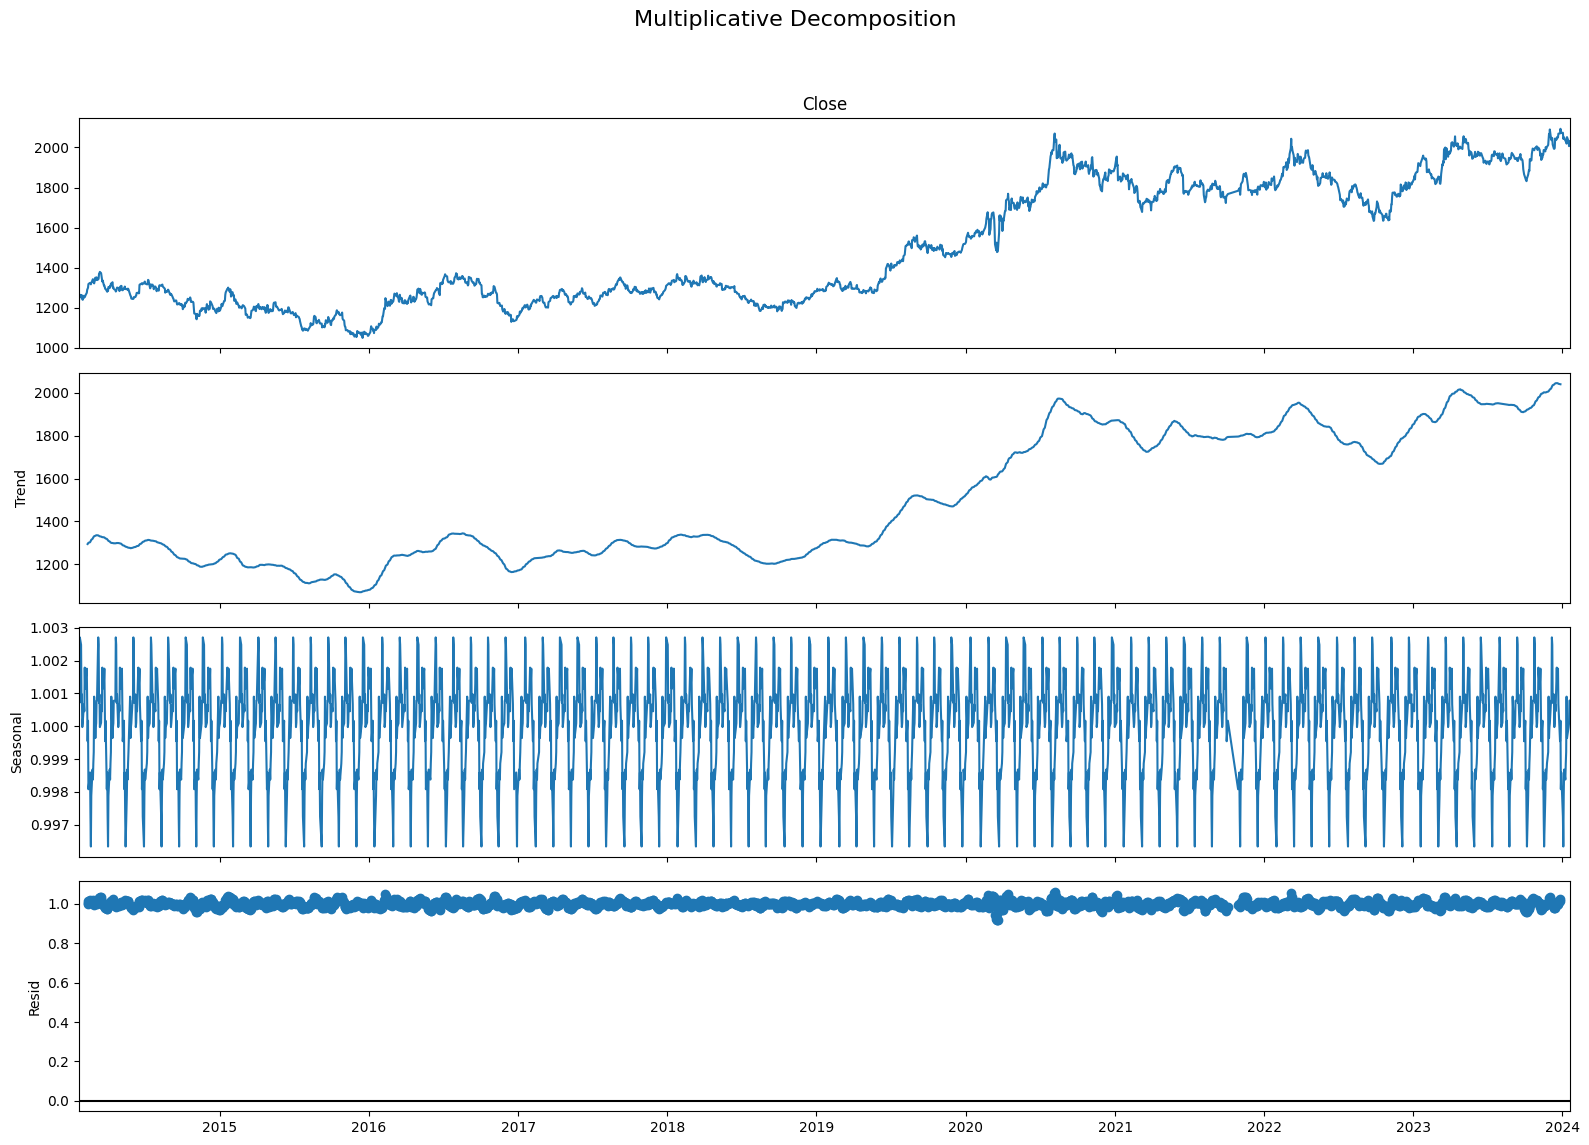

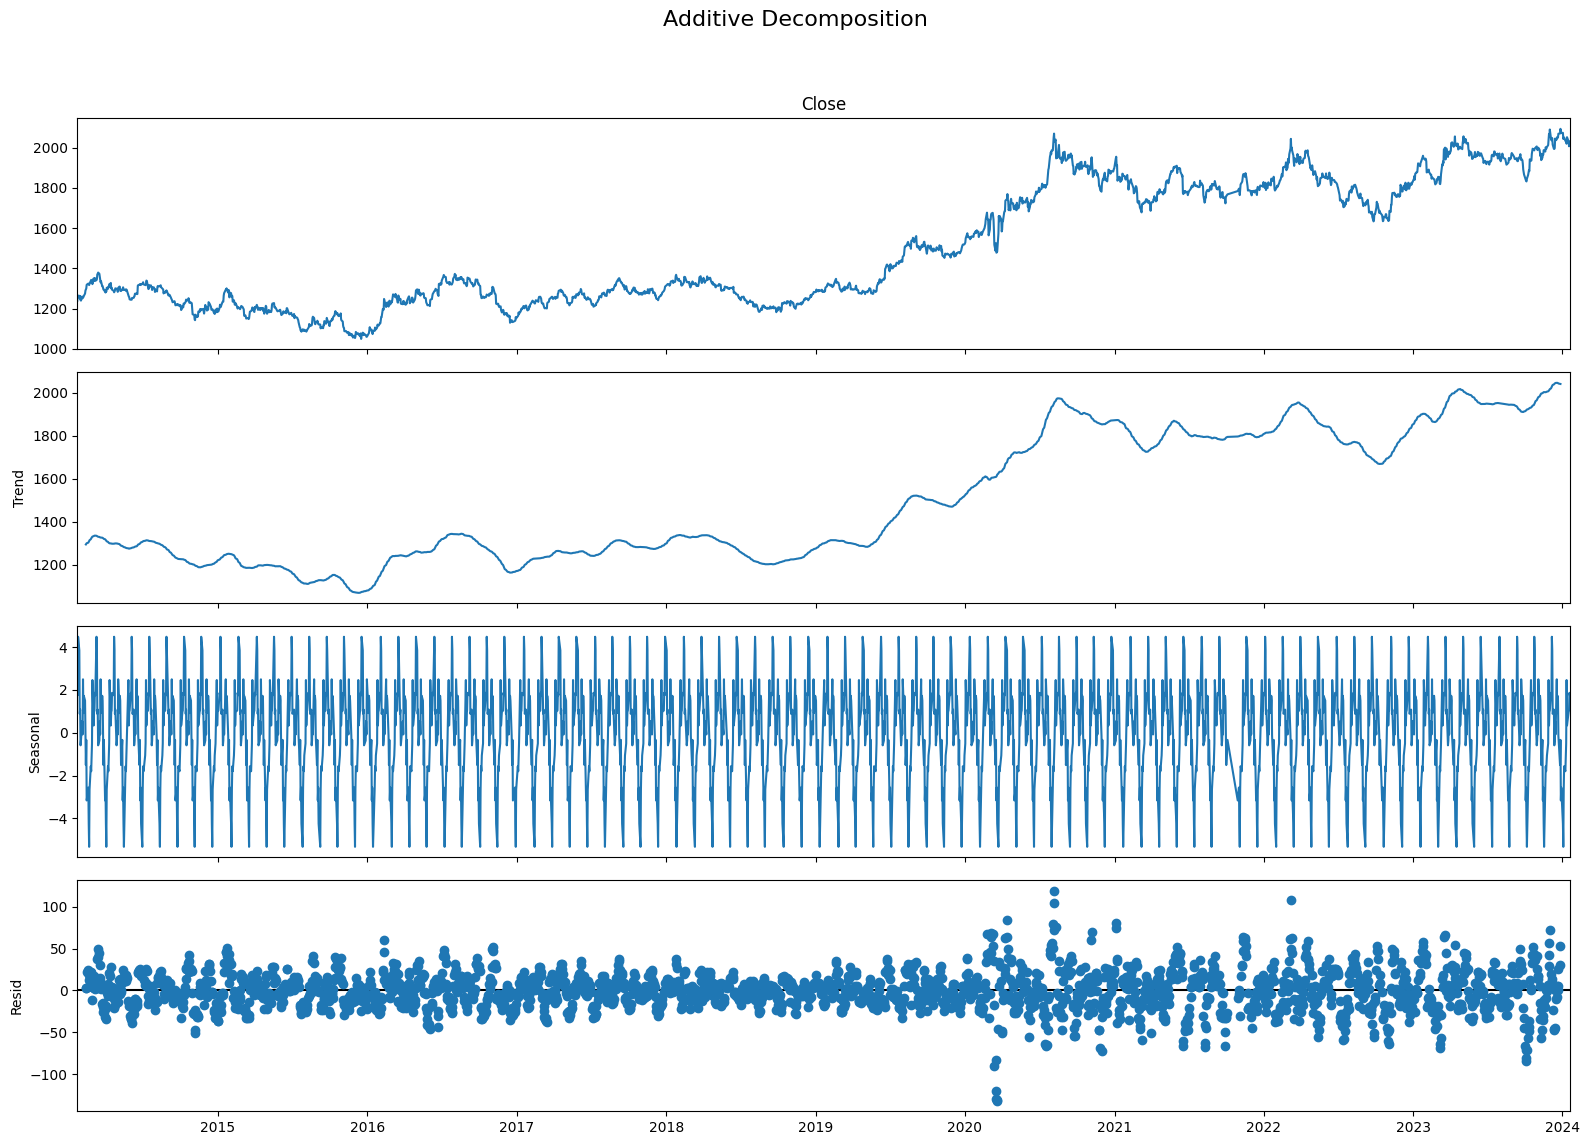

In [28]:
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

In [29]:
data.corr()['Volume']

Close     0.023341
Volume    1.000000
Open      0.027594
High      0.031406
Low       0.018820
Name: Volume, dtype: float64

<Axes: >

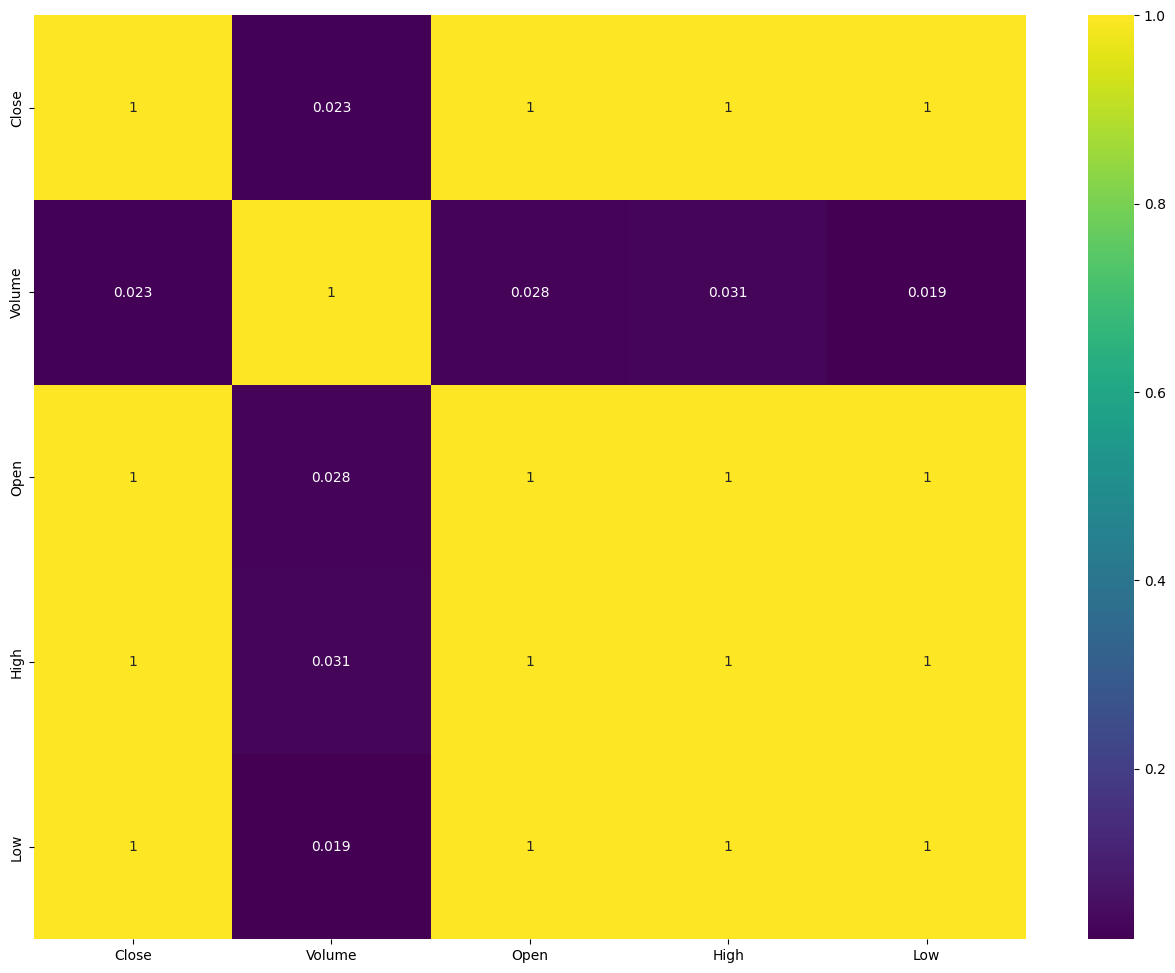

In [30]:
sns.heatmap(data=data.corr(), annot=True, cmap='viridis')

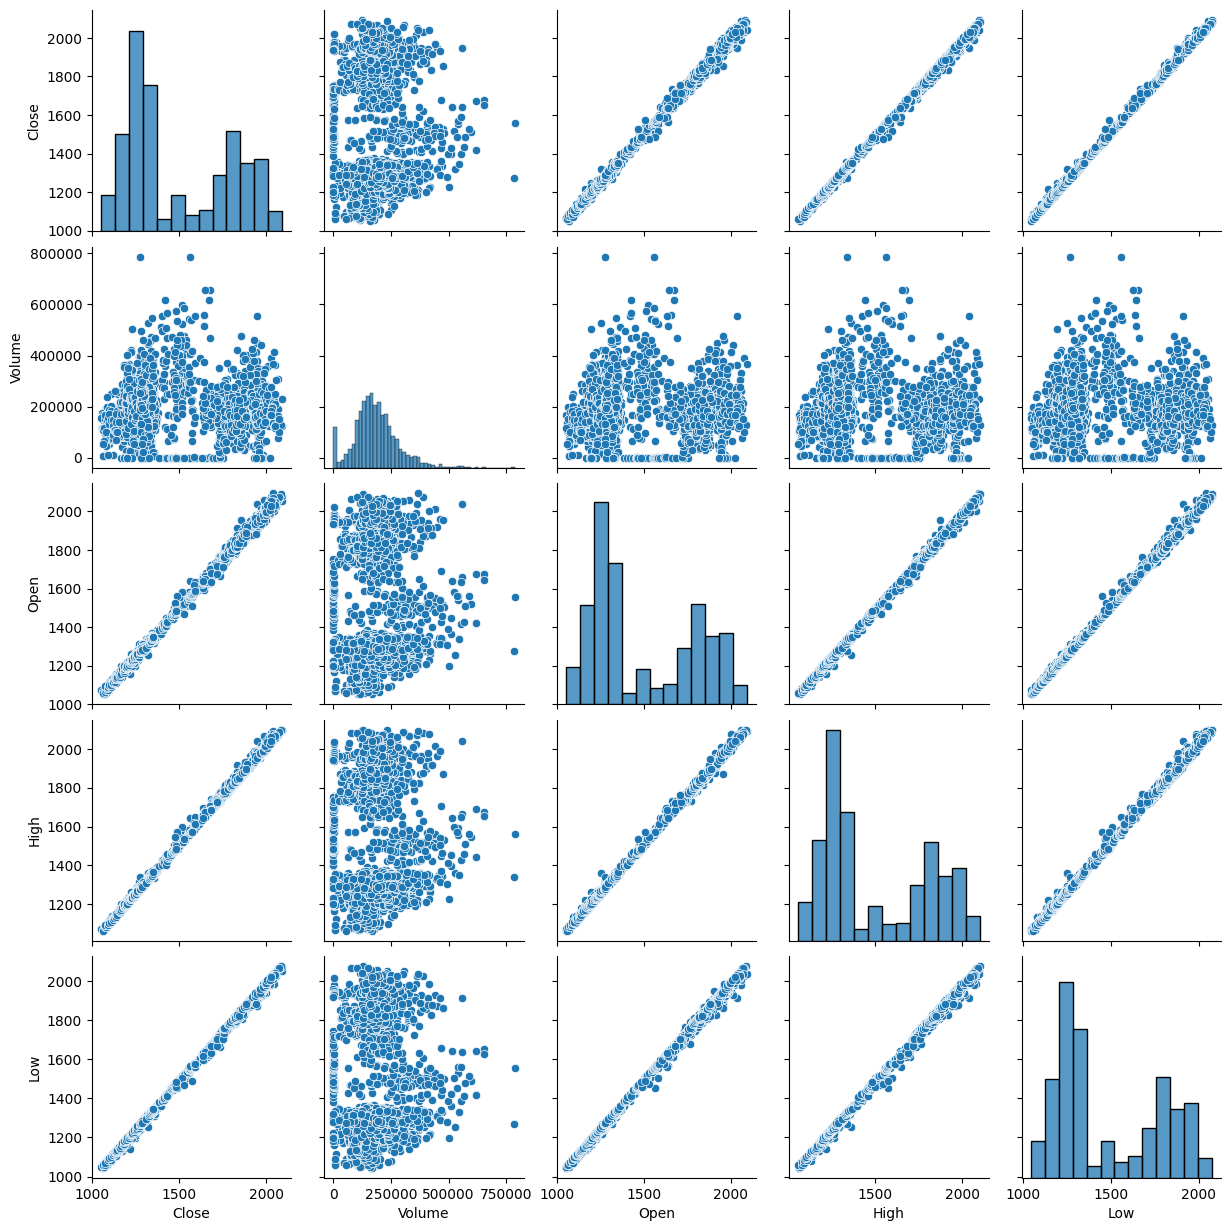

In [31]:
sns.pairplot(data)

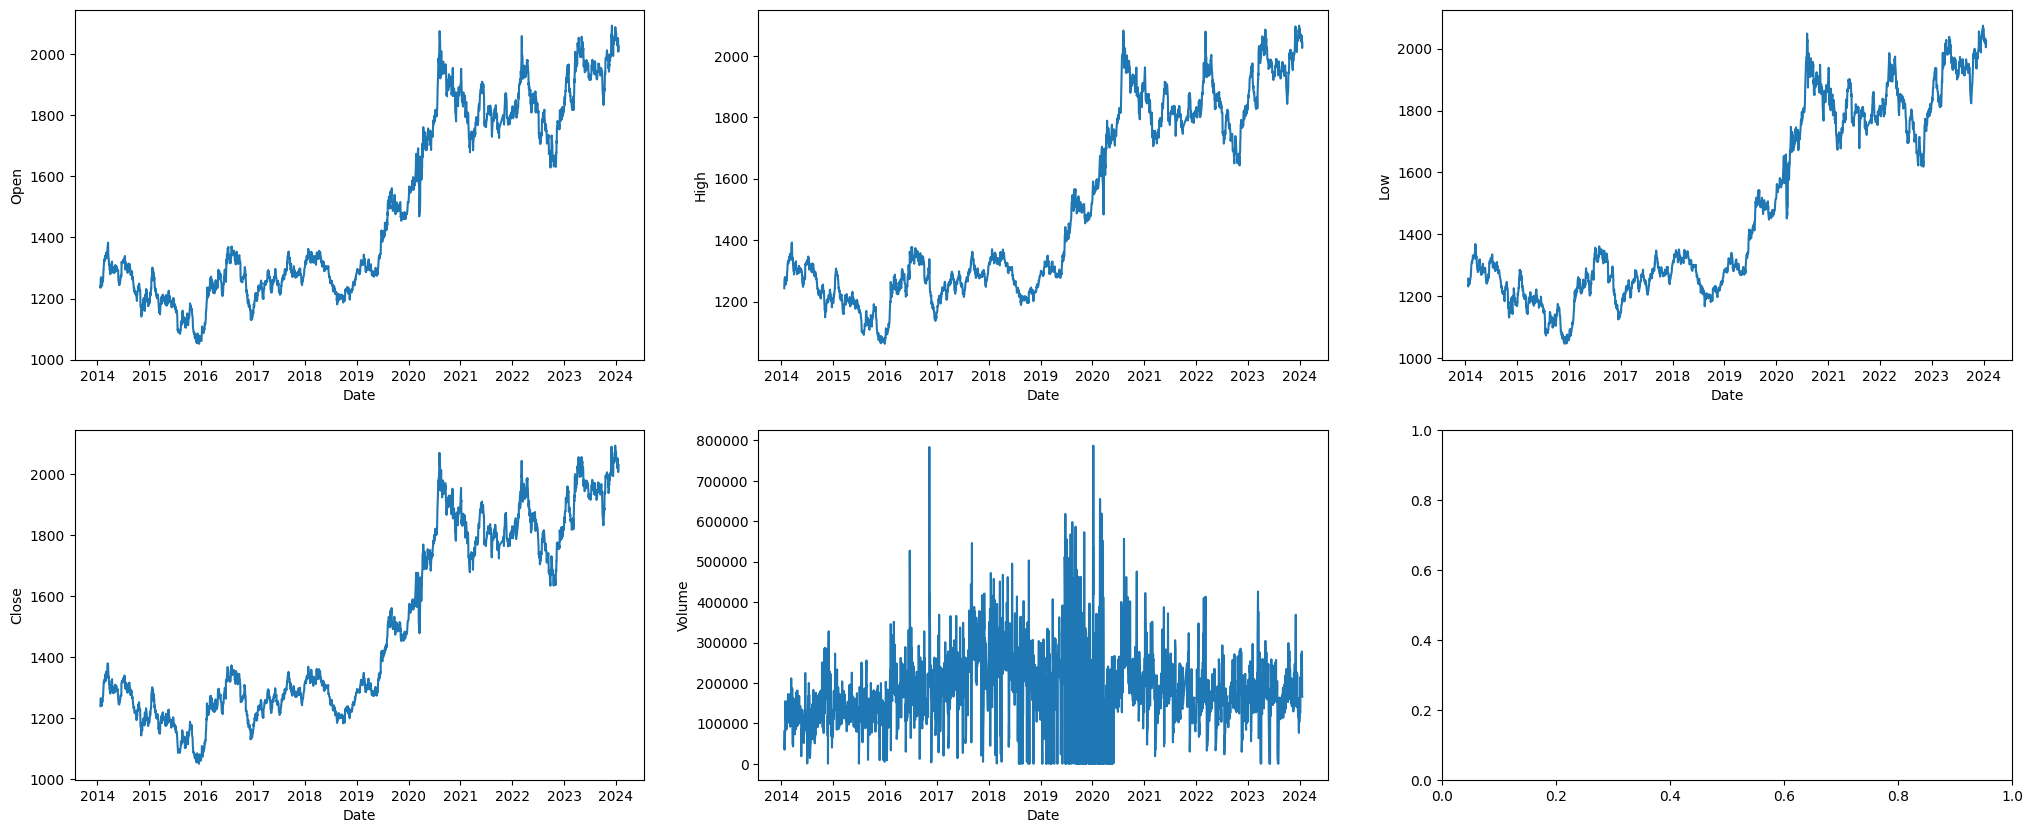

In [32]:
fig, axes = plt.subplots(2, 3, figsize = (25, 10))
axes = axes.flatten()

sns.lineplot(ax = axes[0], x = data.index, y = data["Open"]);
sns.lineplot(ax = axes[1], x = data.index, y = data["High"]);
sns.lineplot(ax = axes[2], x = data.index, y = data["Low"]);
sns.lineplot(ax = axes[3], x = data.index, y = data["Close"]);
sns.lineplot(ax = axes[4], x = data.index, y = data["Volume"]);


In [34]:
fig = px.histogram(data, x = "Close", y = "Volume", marginal = "box", text_auto = True, hover_data  = data.columns)
fig.show()

In [35]:
fig = px.line(y=data.Close, x=data.index)
fig.update_traces(line_color='black') 
fig.update_layout(xaxis_title="Date", 
                  yaxis_title="Close Price",
                  title={'text': "Gold Close Price History Data", 'y':0.95, 'x':0.5, 'xanchor':'center', 'yanchor':'top'},
                  plot_bgcolor='rgba(173,216,230,0.8)')

In [36]:
closedf = data.reset_index()[['Date', 'Close']].rename(columns={'Date':'ds',
                     'Close':'y'})

In [37]:
closedf

ds       y
0    2014-01-22  1238.6
1    2014-01-23  1262.5
2    2014-01-24  1264.5
3    2014-01-27  1263.5
4    2014-01-28  1250.5
...         ...     ...
2487 2024-01-12  2051.6
2488 2024-01-16  2030.2
2489 2024-01-17  2006.5
2490 2024-01-18  2021.6
2491 2024-01-19  2029.3

[2492 rows x 2 columns]

In [38]:
m = Prophet(interval_width=0.95, daily_seasonality=True)
prophet = m.fit(closedf)

08:05:05 - cmdstanpy - INFO - Chain [1] start processing
08:05:07 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
future = m.make_future_dataframe(periods=100,freq='D')
forecast = m.predict(future)
forecast.head()

ds        trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
0 2014-01-22  1247.866451  1214.263088  1431.490258  1247.866451  1247.866451   
1 2014-01-23  1247.633734  1213.774951  1417.355012  1247.633734  1247.633734   
2 2014-01-24  1247.401018  1213.082907  1420.785097  1247.401018  1247.401018   
3 2014-01-27  1246.702868  1204.868543  1415.342317  1246.702868  1246.702868   
4 2014-01-28  1246.470151  1210.947314  1416.491839  1246.470151  1246.470151   

   additive_terms  additive_terms_lower  additive_terms_upper      daily  ...  \
0       68.514305             68.514305             68.514305  58.778769  ...   
1       69.442297             69.442297             69.442297  58.778769  ...   
2       69.335095             69.335095             69.335095  58.778769  ...   
3       68.383533             68.383533             68.383533  58.778769  ...   
4       68.696281             68.696281             68.696281  58.778769  ...   

     weekly  weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0  2.428223      2.428223      2.428223  7.307313      7.307313      7.307313   
1  3.400812      3.400812      3.400812  7.262715      7.262715      7.262715   
2  3.351387      3.351387      3.351387  7.204939      7.204939      7.204939   
3  2.580106      2.580106      2.580106  7.024658      7.024658      7.024658   
4  2.934147      2.934147      2.934147  6.983365      6.983365      6.983365   

   multiplicative_terms  multiplicative_terms_lower  \
0                   0.0                         0.0   
1                   0.0                         0.0   
2                   0.0                         0.0   
3                   0.0                         0.0   
4                   0.0                         0.0   

   multiplicative_terms_upper         yhat  
0                         0.0  1316.380757  
1                         0.0  1317.076031  
2                         0.0  1316.736112  
3                         0.0  1315.086401  
4                         0.0  1315.166432  

[5 rows x 22 columns]

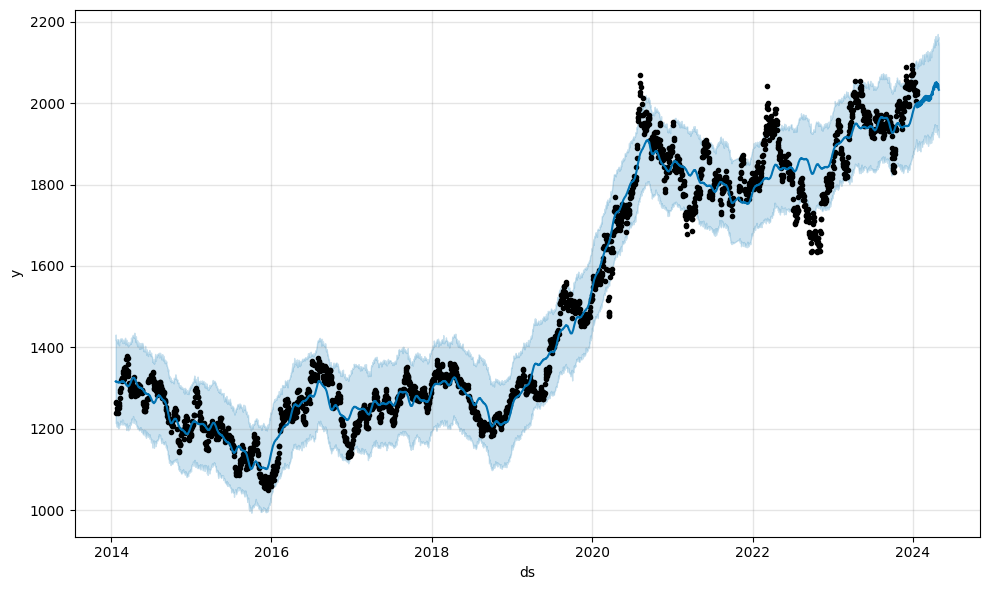

In [43]:
m.plot(forecast);

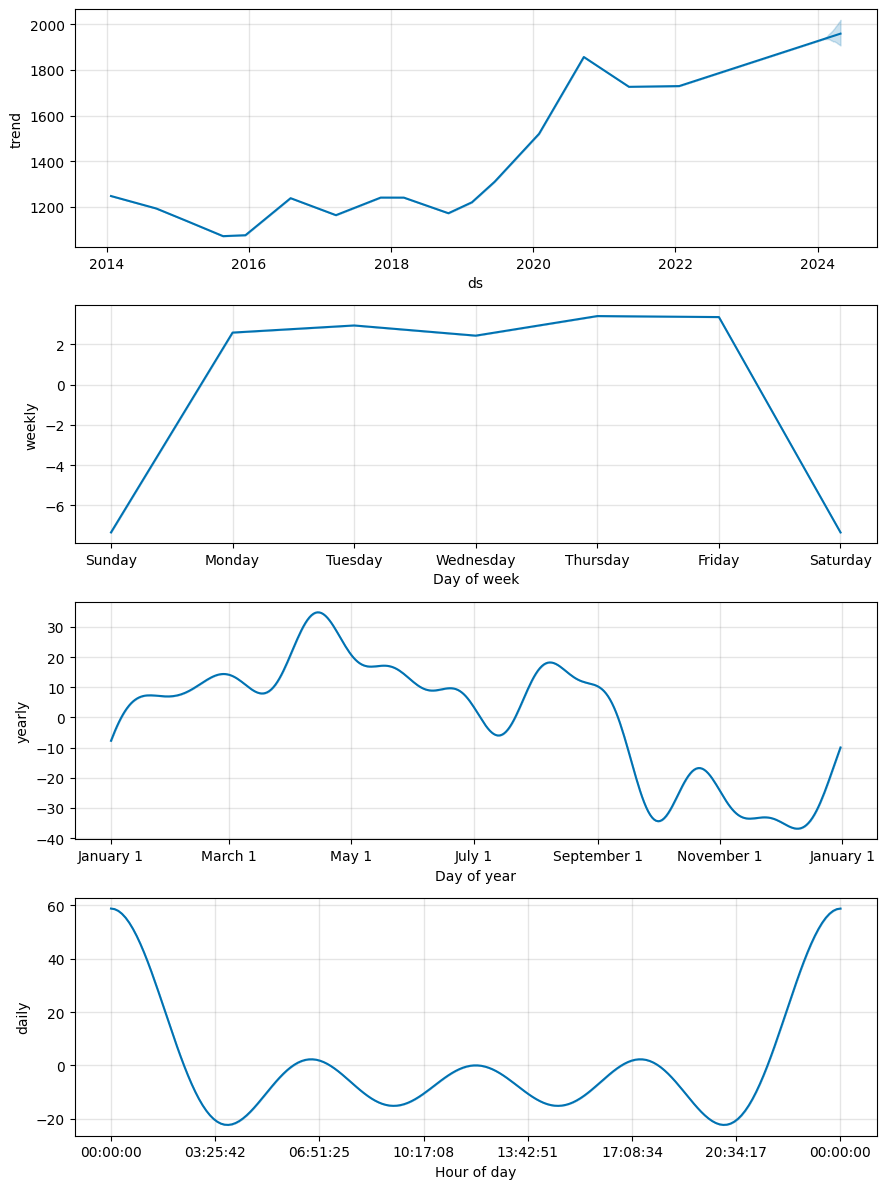

In [44]:
m.plot_components(forecast);

In [45]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series,title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') 
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        

In [46]:
# use ADF function       
adf_test(data['Close'])

Augmented Dickey-Fuller Test: 
ADF test statistic        -0.640318
p-value                    0.861609
# lags used                1.000000
# observations          2490.000000
critical value (1%)       -3.432979
critical value (5%)       -2.862701
critical value (10%)      -2.567388
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


## Split data plot

In [32]:
test_size = data[data.index.year>2021].shape[0]
test_size

511

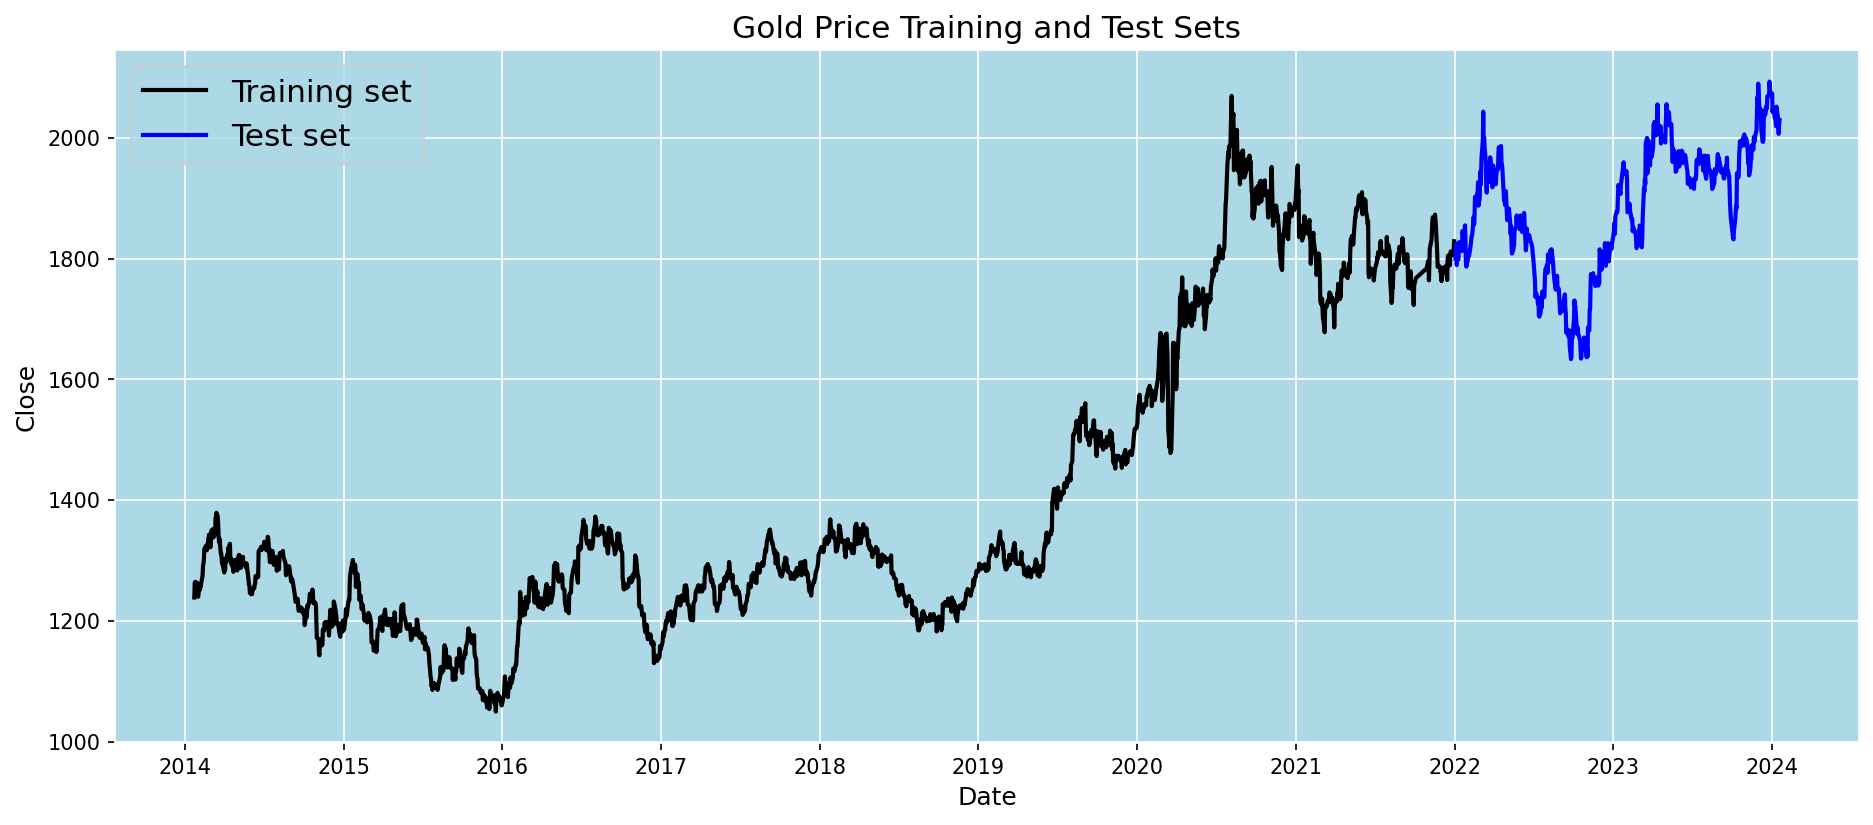

In [33]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'lightblue'
plt.rc('axes',edgecolor='white')
plt.plot(data.index[:-test_size], data.Close[:-test_size], color='black', lw=2)
plt.plot(data.index[-test_size:], data.Close[-test_size:], color='blue', lw=2)
plt.title('Gold Price Training and Test Sets', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close', fontsize=12)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

## Scale data

In [34]:
scaler = MinMaxScaler()

In [35]:
scaler.fit(data.Close.values.reshape(-1,1))

MinMaxScaler()

## Split data

In [36]:
window_size = 60

In [37]:
train_data = data.Close[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [38]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [39]:
len(X_train)

1921

In [40]:
X_train[:2]

[array([0.18112123, 0.20402492, 0.20594154, 0.20498323, 0.19252516,
        0.20373742, 0.18485865, 0.1822712 , 0.2015333 , 0.19319598,
        0.19865836, 0.19894586, 0.20440824, 0.21571634, 0.23018687,
        0.2351701 , 0.2400575 , 0.2577863 , 0.26334451, 0.25951126,
        0.25615716, 0.26257786, 0.27637758, 0.28088165, 0.26679444,
        0.27043603, 0.26066124, 0.28816483, 0.27628174, 0.2785817 ,
        0.2896023 , 0.27656924, 0.27973167, 0.2847149 , 0.30752276,
        0.30934356, 0.31566842, 0.30982271, 0.29650216, 0.27954001,
        0.26919023, 0.27446095, 0.25059895, 0.25088644, 0.24321993,
        0.23497844, 0.23449928, 0.22443699, 0.2207954 , 0.23114518,
        0.22520364, 0.24331576, 0.23833253, 0.24868232, 0.24561572,
        0.25960709, 0.25816962, 0.26631529, 0.24024916, 0.24331576]),
 array([0.20402492, 0.20594154, 0.20498323, 0.19252516, 0.20373742,
        0.18485865, 0.1822712 , 0.2015333 , 0.19319598, 0.19865836,
        0.19894586, 0.20440824, 0.21571634, 0.

In [41]:
test_data = data.Close[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [42]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

In [43]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [44]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [45]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (1921, 60, 1)
y_train Shape:  (1921, 1)
X_test Shape:   (511, 60, 1)
y_test Shape:   (511, 1)


In [46]:
def validate_result(model, model_name, n_periods=None):
    if n_periods is None:
        predicted = model.predict(X_test)
    else:
        predicted = model.predict(n_periods= n_periods, X=X_test)

    RMSE_score = np.sqrt(mean_squared_error(y_test, predicted))
    print(f'{model_name} RMSE: ', RMSE_score)

    y_tes  = np.reshape(y_test, (-1,1))
    y_pred = np.reshape(predicted, (-1,1))
    y_test_true = scaler.inverse_transform(y_tes)
    y_test_pred = scaler.inverse_transform(y_pred)
    
    plt.figure(figsize=(15, 6), dpi=150)
    plt.rcParams['axes.facecolor'] = 'lightblue'
    plt.rc('axes',edgecolor='white')
    plt.plot(data.index[-test_size:], y_test_true, color='blue', lw=2)
    plt.plot(data.index[-test_size:], y_test_pred, color='red', lw=2)
    plt.title(f'{model_name} Model Performance on Gold Price Prediction', fontsize=15)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Close', fontsize=12)
    plt.legend(['Actual Test Data', 'Predicted Test Data'], loc='upper left', prop={'size': 15})
    plt.grid(color='white')
    plt.show()

    return RMSE_score


## LSTM

In [47]:
def define_model():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 64, return_sequences=True)(input1)  
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 64)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='Nadam', metrics=['mean_absolute_error'])
    model.summary()
    
    return model

In [48]:
model = define_model()
history = model.fit(X_train, y_train, epochs=150, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,057 (332.25 KB)

 Trainable params: 85,057 (332.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 0.0960 - mean_absolute_error: 0.2331 - val_loss: 0.1728 - val_mean_absolute_error: 0.4132
Epoch 2/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0449 - mean_absolute_error: 0.1608 - val_loss: 0.1765 - val_mean_absolute_error: 0.4176
Epoch 3/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0477 - mean_absolute_error: 0.1688 - val_loss: 0.1785 - val_mean_absolute_error: 0.4199
Epoch 4/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0486 - mean_absolute_error: 0.1685 - val_loss: 0.1839 - val_mean_absolute_error: 0.4263
Epoch 5/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0478 - mean_absolute_error: 0.1648 - val_loss: 0.1801 - val_mean_absolute_error: 0.4218
Epoch 6/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0432 - mean_absolute_error: 0.1549 - val_loss: 0.1748 - val_mean_absolute_error: 0.4156
Epoch 7/150
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.0457 - mean_absolute_error: 0.1616 - v

In [49]:
result = model.evaluate(X_test, y_test)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 8.8469e-04 - mean_absolute_error: 0.0239


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step
LSTM RMSE:  0.034396236909328456


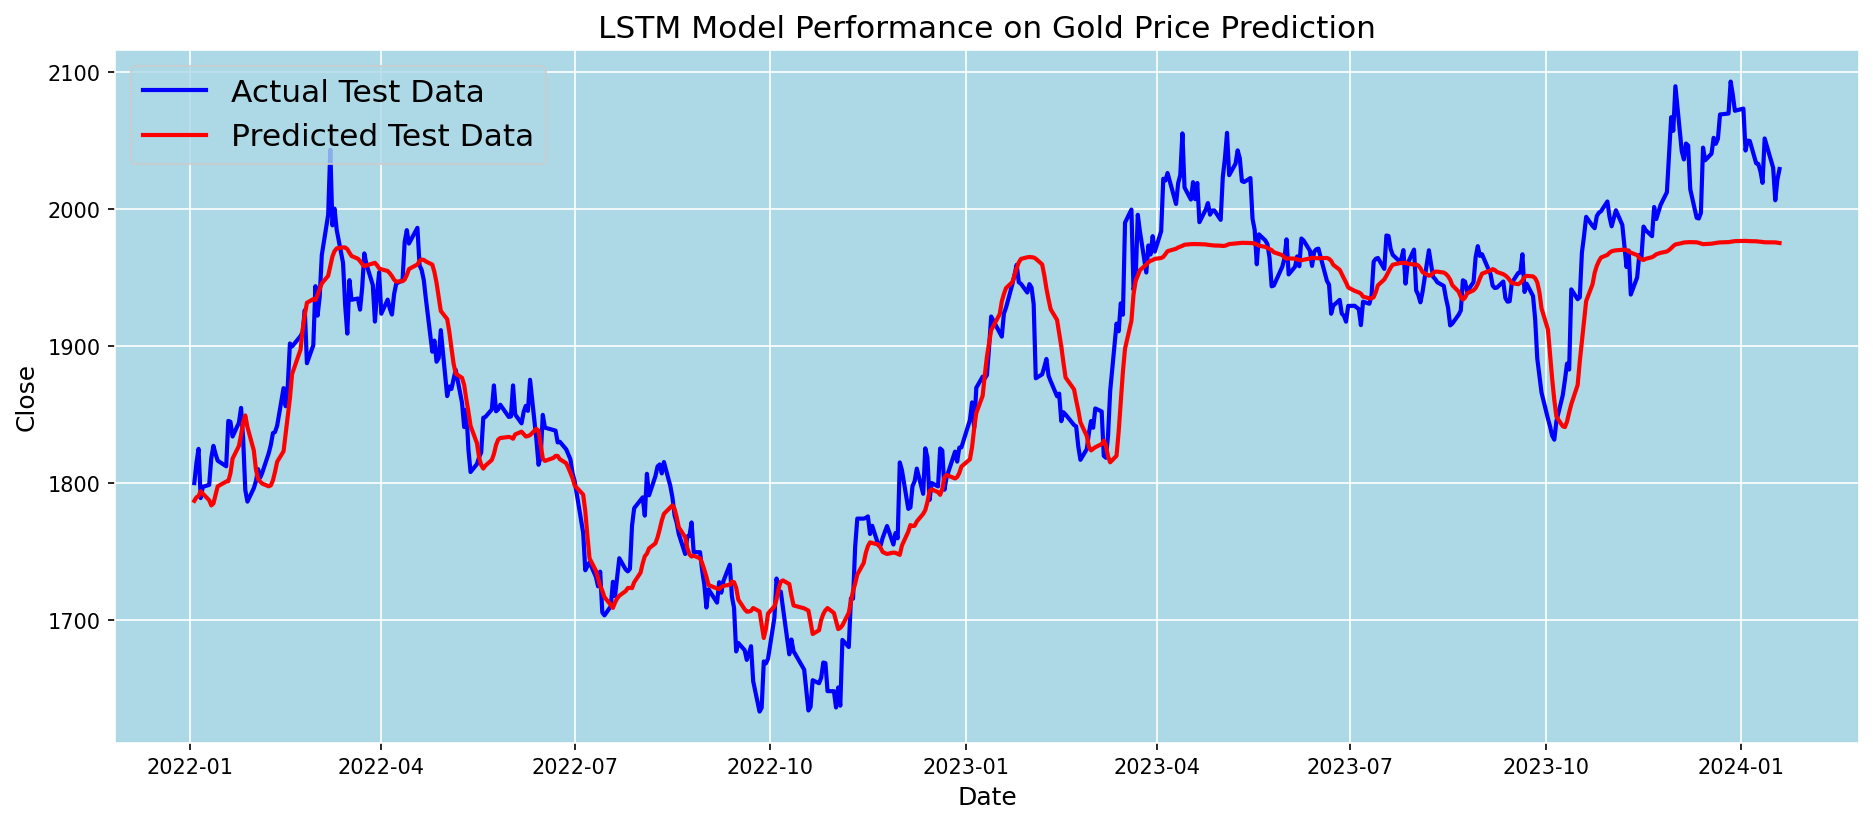

In [50]:
LSTM_RMSE = validate_result(model, 'LSTM')

In [51]:
LSTM_RMSE

0.034396236909328456

## Run the Data Split to remove shape used in LSTM

In [52]:
window_size = 60
train_data = data.Close[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

test_data = data.Close[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

## Decision Tree

In [53]:
from sklearn.tree import DecisionTreeRegressor

In [54]:
dt = DecisionTreeRegressor(random_state=0)

In [55]:
benchmark_dt=dt.fit(X_train, y_train)

Decision Tree Regression RMSE:  0.06890698572281154


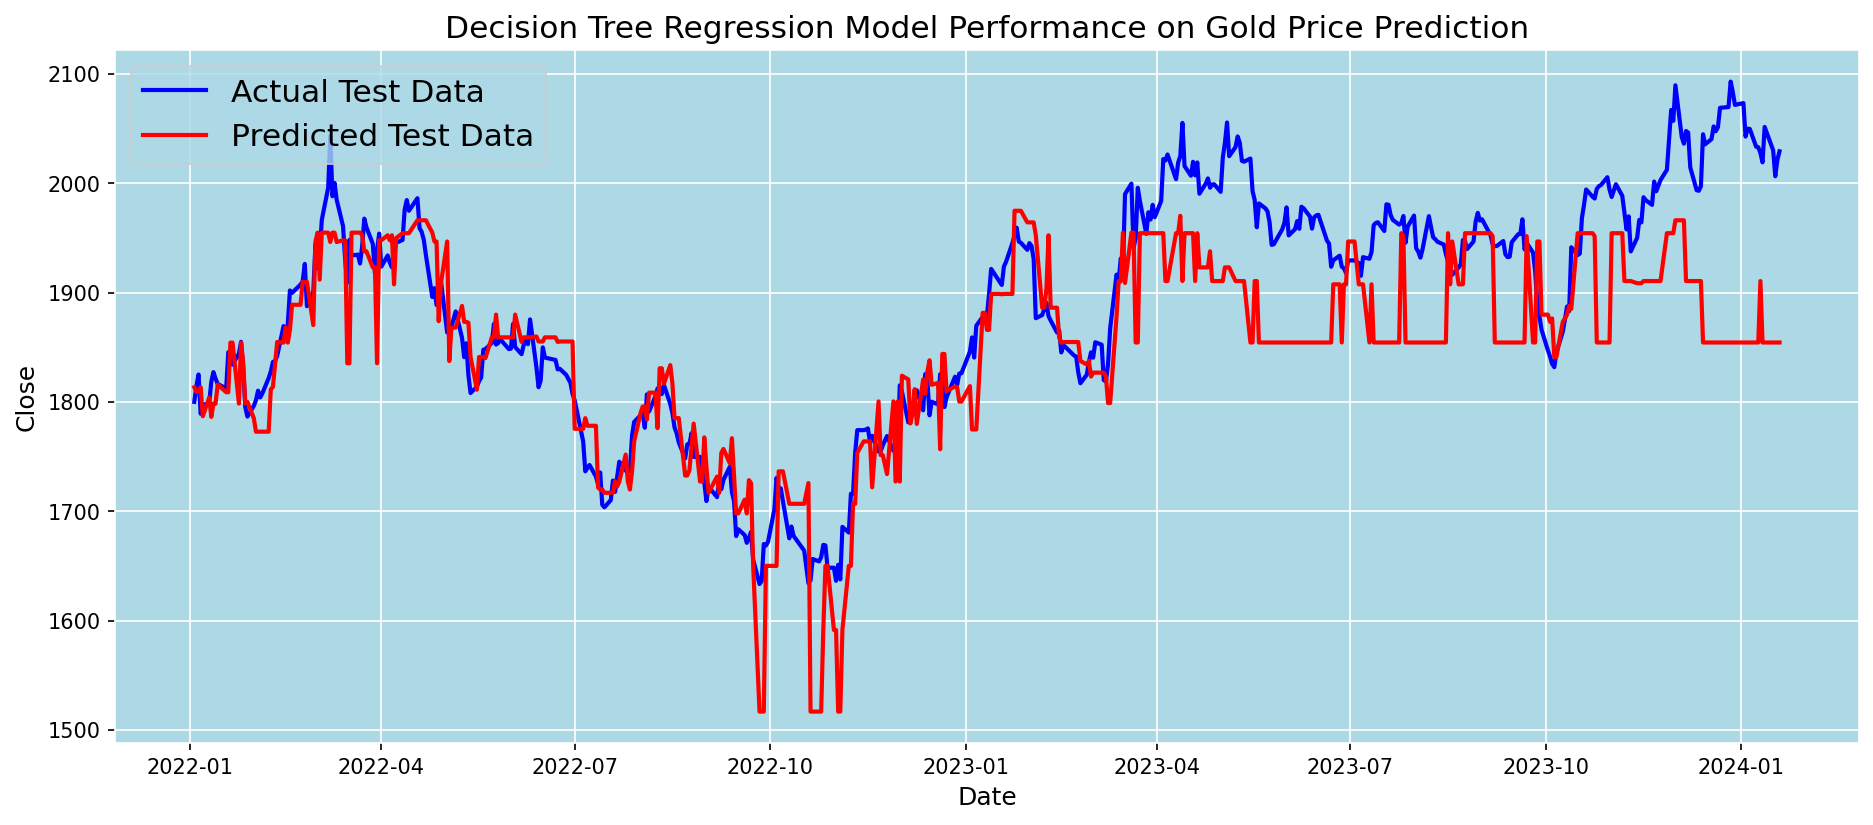

In [56]:
DT_RMSE = validate_result(benchmark_dt, 'Decision Tree Regression')

## Support Vector Regressor

In [57]:
from sklearn.svm import SVR

Linear SVR RMSE:  0.04083294805188364


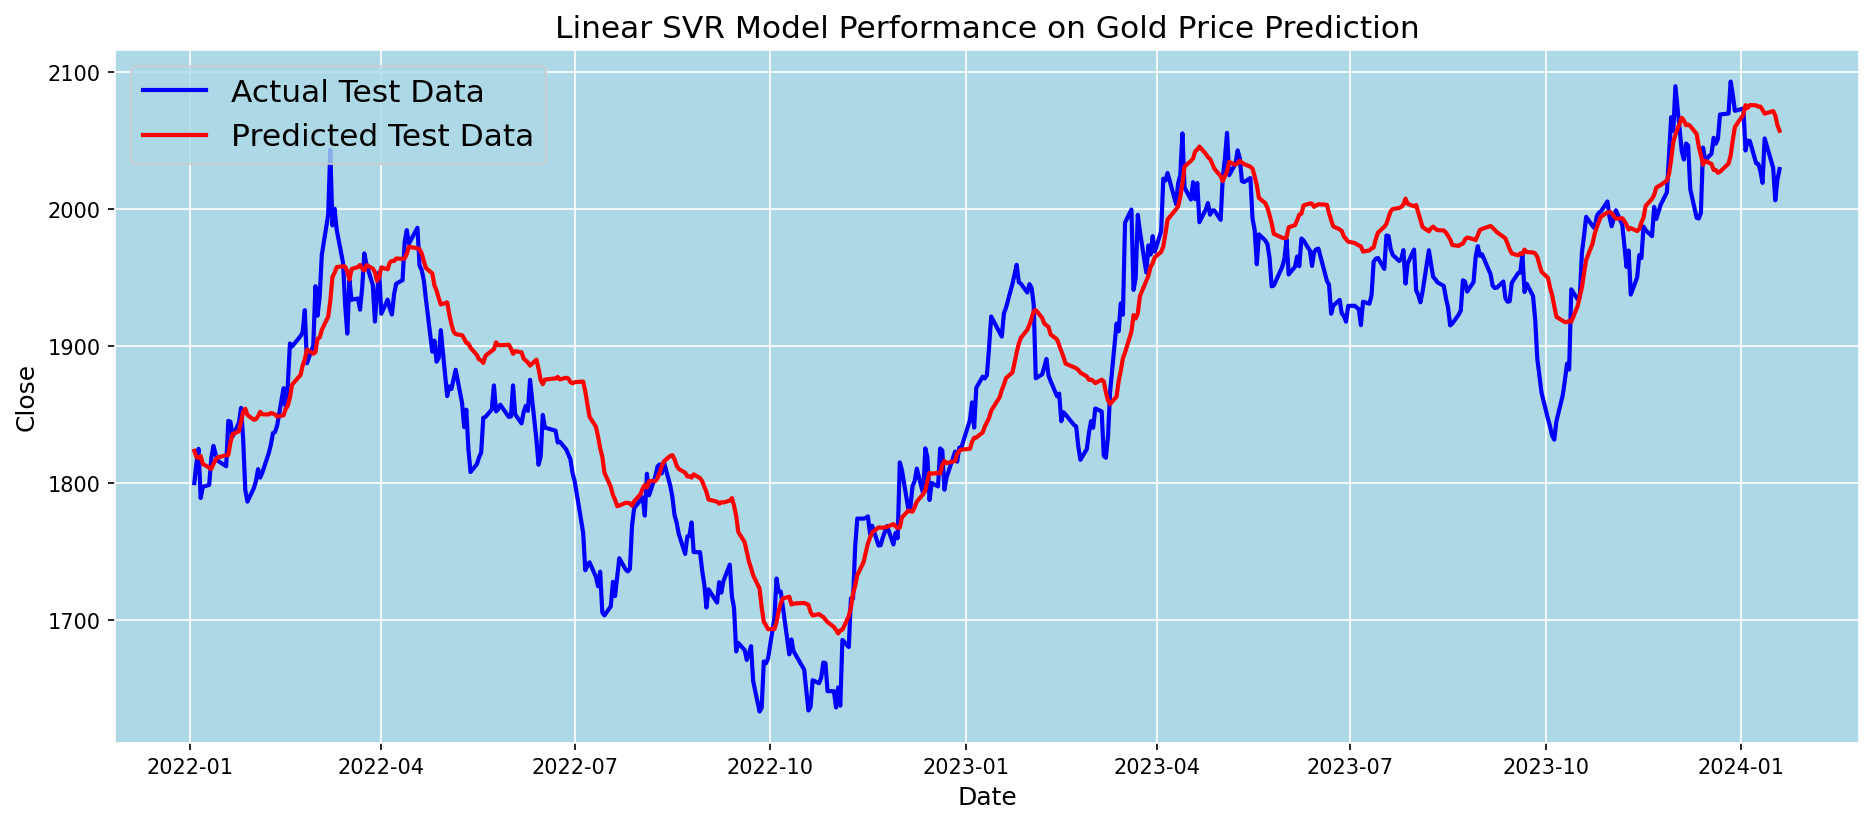

In [58]:
# SVR with  linear Kernel
svr_lin = SVR(kernel='linear')
linear_svr_clf_feat = svr_lin.fit(X_train,y_train)

LSVR_RMSE = validate_result(linear_svr_clf_feat,'Linear SVR')

In [59]:
LSVR_RMSE

0.04083294805188364

## Random Forest Regressor

In [60]:
from sklearn.ensemble import RandomForestRegressor

Random Forest RMSE:  0.04063601930868681


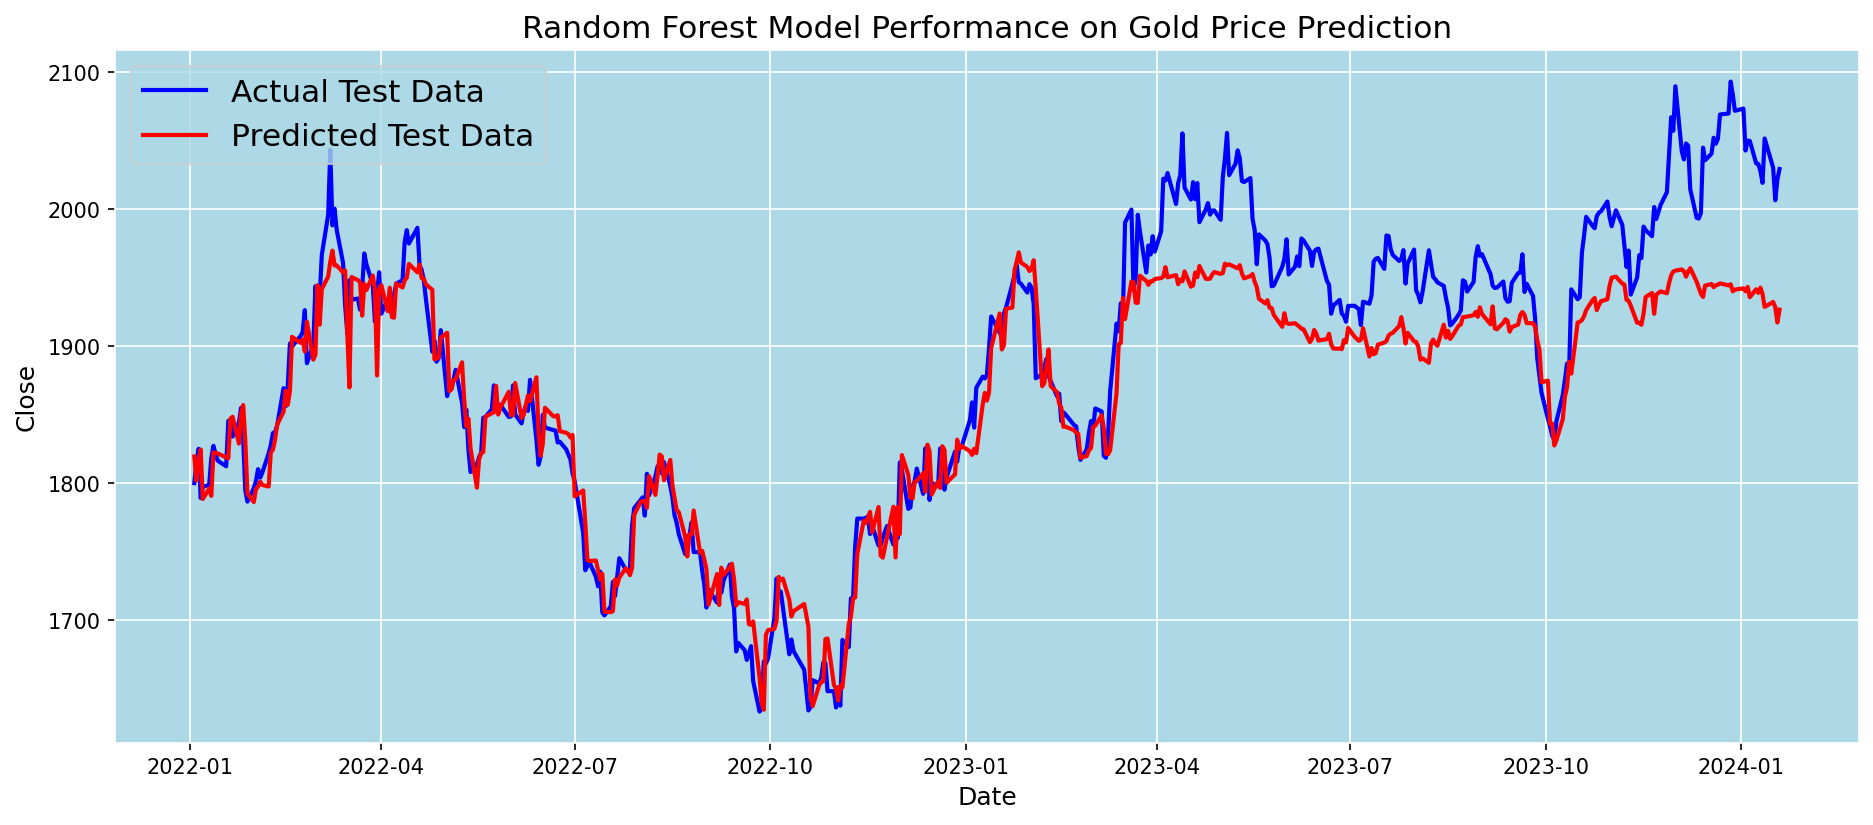

In [61]:
rf_cl = RandomForestRegressor(n_estimators=50, random_state=0)
random_forest_clf_feat = rf_cl.fit(X_train,y_train)
RFR_RMSE = validate_result(random_forest_clf_feat,'Random Forest')

In [62]:
RFR_RMSE

0.04063601930868681

## Lasso and Ridge

In [63]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV

lasso_clf = LassoCV(n_alphas=1000, max_iter=3000, random_state=0)
ridge_clf = RidgeCV(gcv_mode='auto')

LassoCV RMSE:  0.016637855995505123


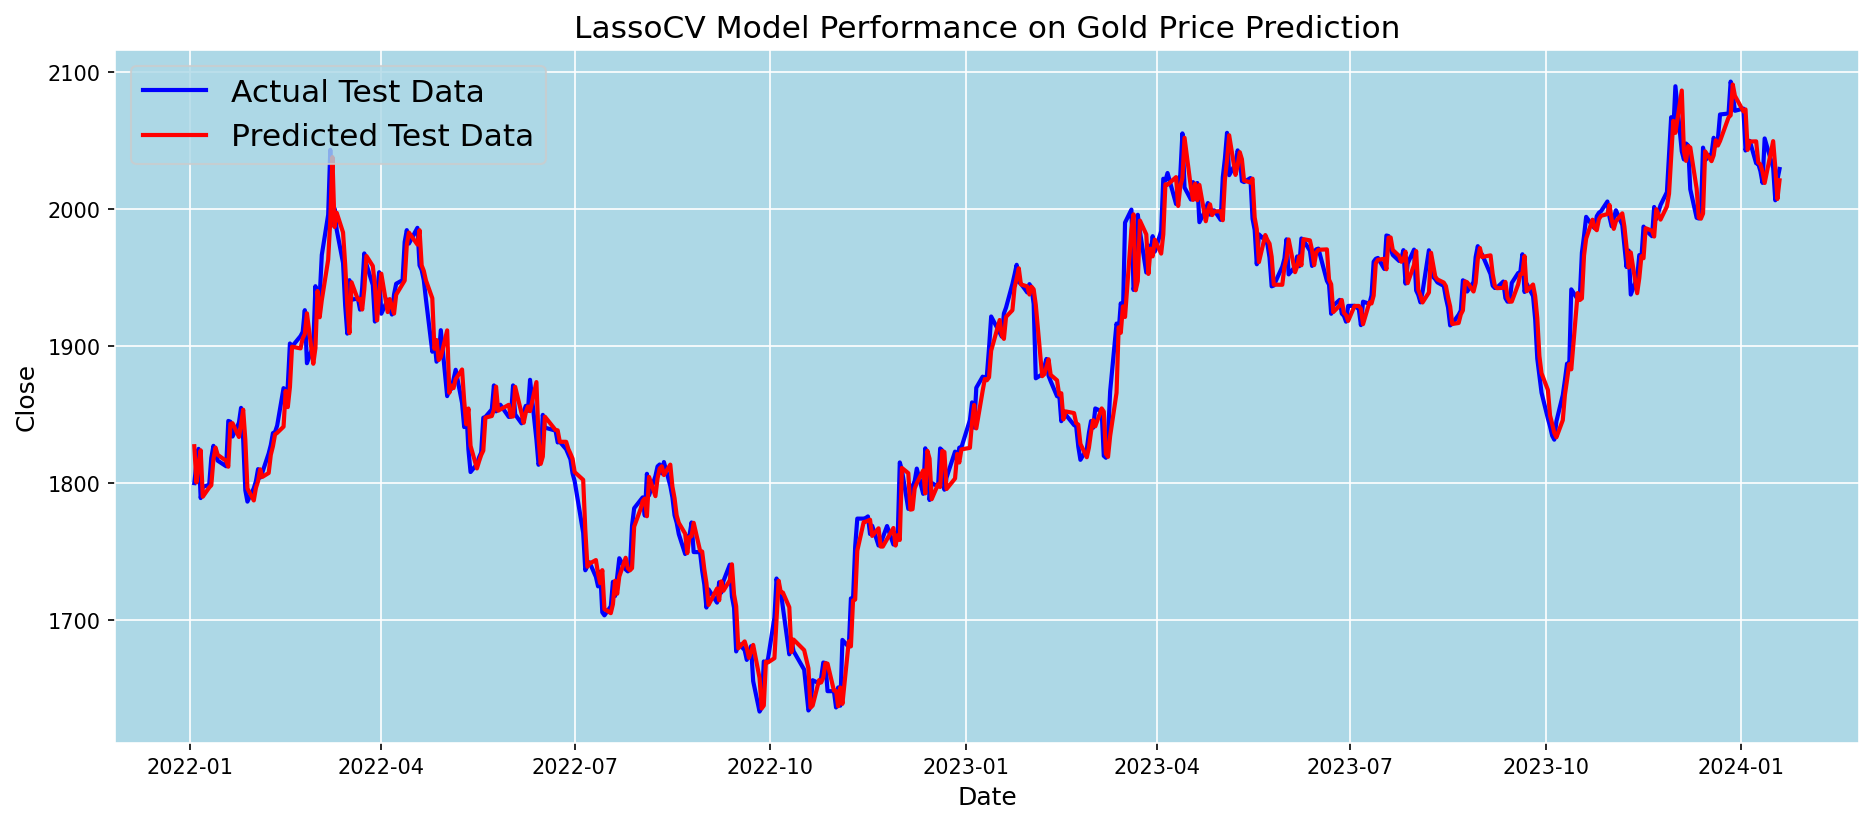

In [64]:
lasso_clf_feat = lasso_clf.fit(X_train,y_train)
LASSO_RMSE = validate_result(lasso_clf_feat,'LassoCV')

RidgeCV RMSE:  0.017138776504330572


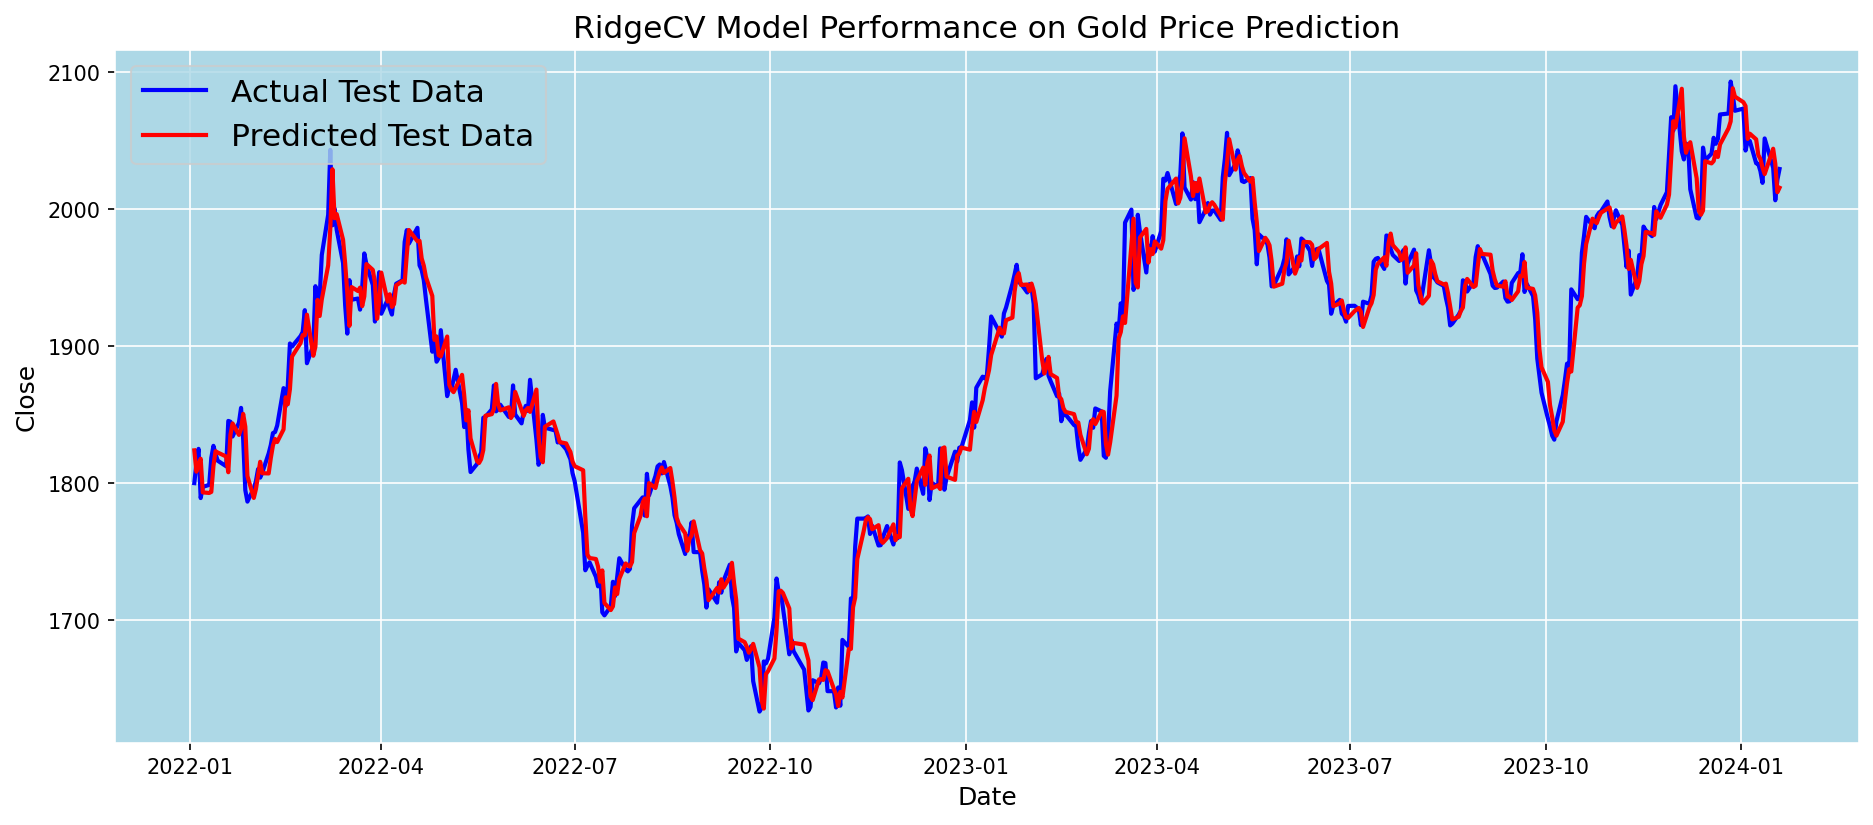

In [65]:
ridge_clf_feat = ridge_clf.fit(X_train,y_train)
RIDGE_RMSE= validate_result(ridge_clf_feat,'RidgeCV')

In [66]:
RIDGE_RMSE

0.017138776504330572

## XGBoost

In [67]:
from xgboost import XGBRegressor

In [68]:
xgb = XGBRegressor(n_estimators=1000)

In [69]:
xgb_feat = xgb.fit(X_train, y_train)

XGBoost RMSE:  0.04127774392954231


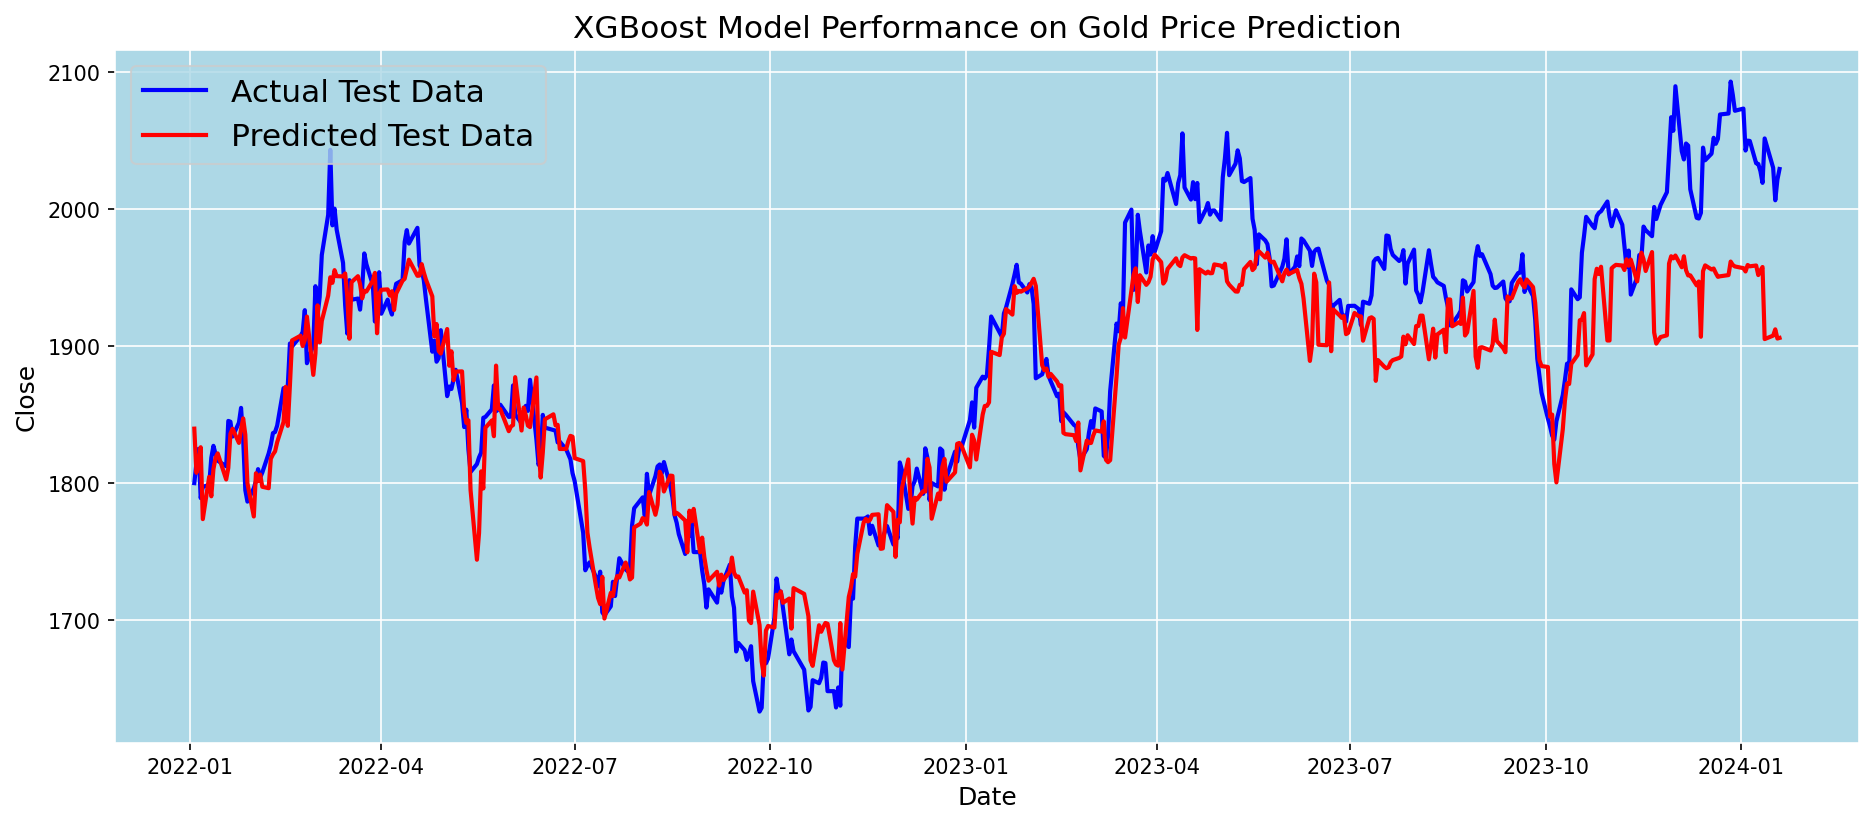

In [70]:
XGB_RMSE= validate_result(xgb_feat,'XGBoost')

In [71]:
XGB_RMSE

0.04127774392954231

## Gradient Boosting Regressor

In [72]:
from sklearn.ensemble import GradientBoostingRegressor

In [73]:
regr = GradientBoostingRegressor(n_estimators=70, learning_rate=0.1,max_depth=4, random_state=0)

In [74]:
GB_feat = regr.fit(X_train,y_train)

Gradient Boosting RMSE:  0.02863477477228079


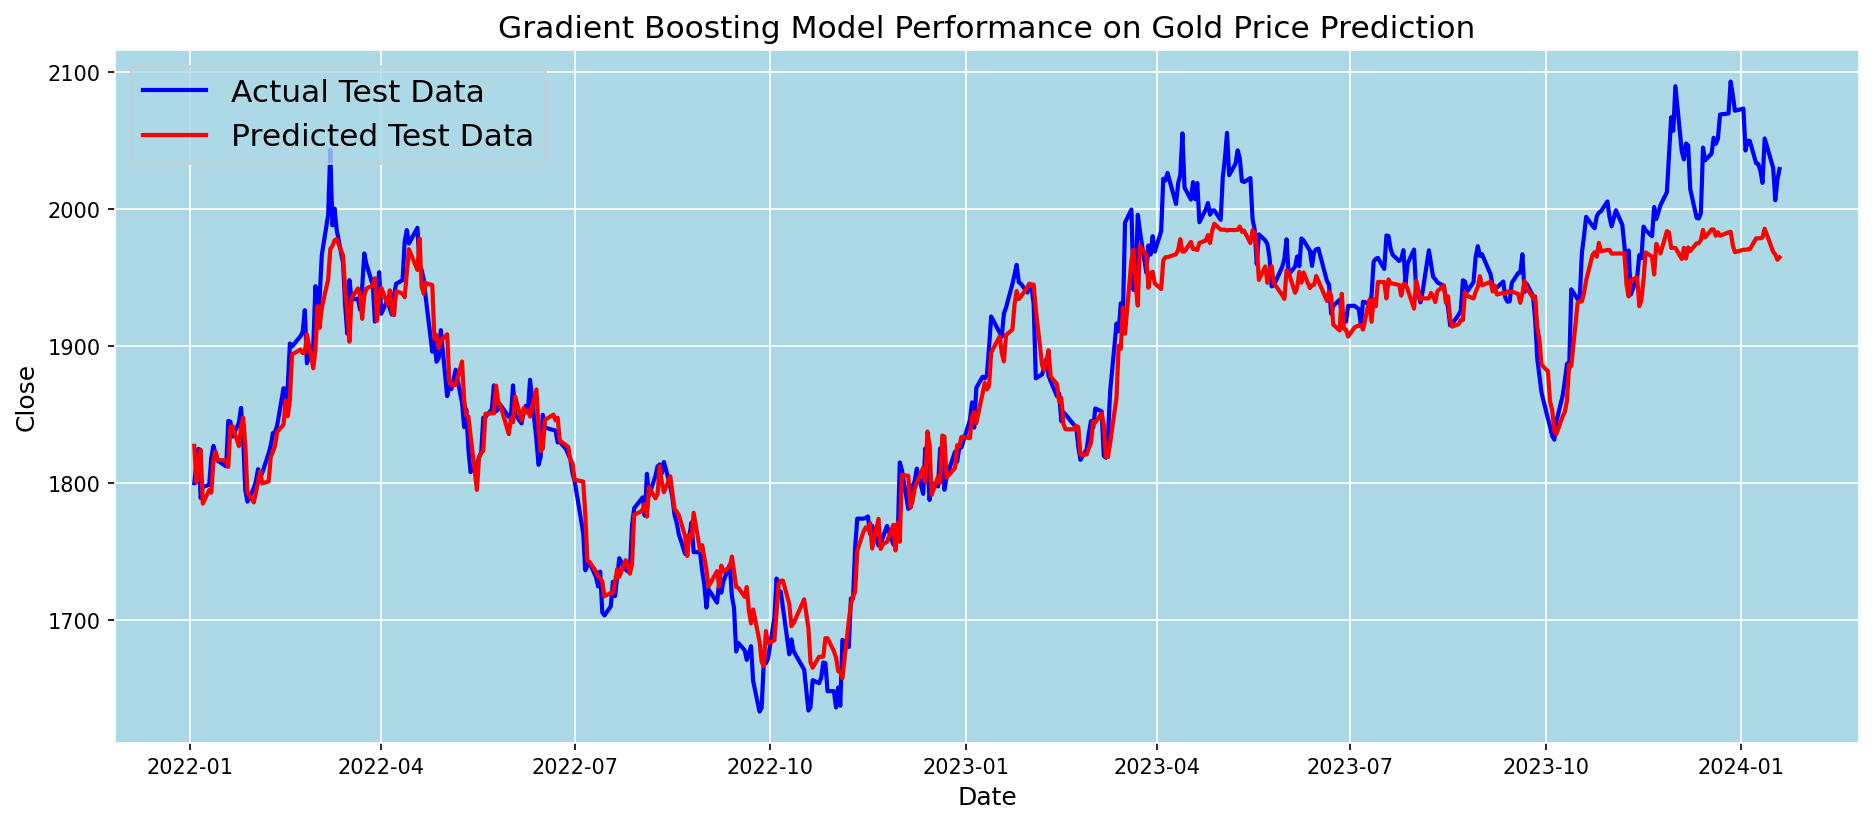

In [75]:
GBR_RMSE = validate_result(GB_feat,'Gradient Boosting')

In [76]:
GBR_RMSE

0.02863477477228079

ARIMA

In [77]:
from pmdarima import auto_arima

In [78]:
model = auto_arima(y= y_train, X= X_train, m=7)

ARIMA RMSE:  0.01711735931960574


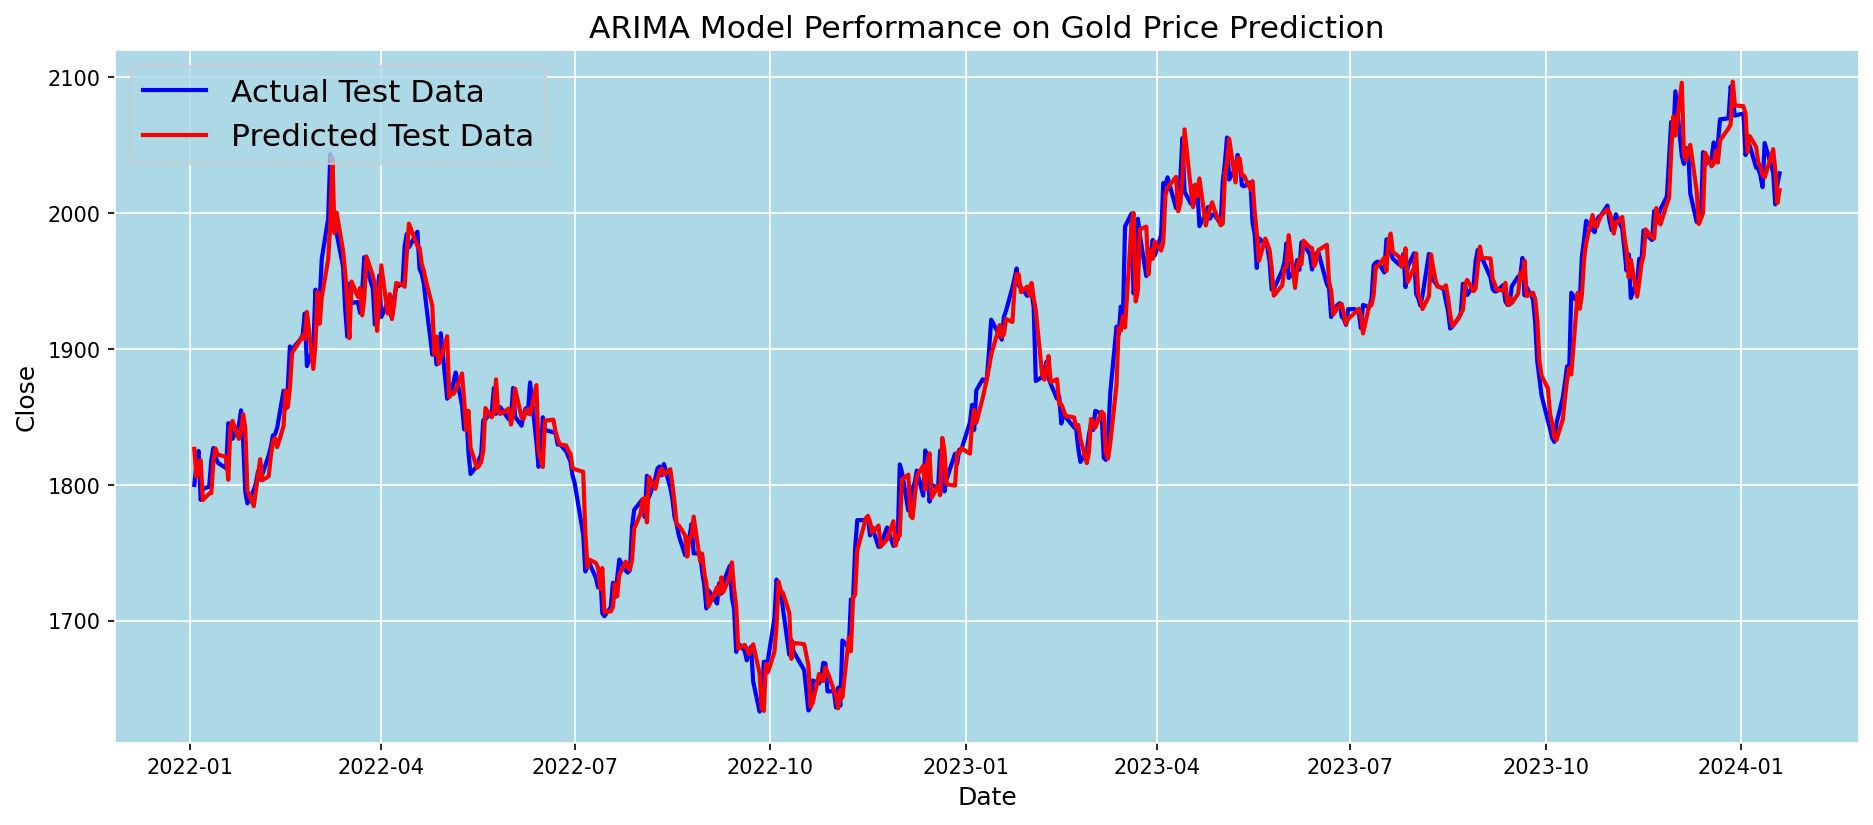

In [79]:
ARIMA_RMSE = validate_result(model, 'ARIMA', n_periods=511)

In [80]:
ARIMA_RMSE

0.01711735931960574

## Performance Metrics

In [81]:
p_met = pd.DataFrame([LSTM_RMSE, DT_RMSE, LSVR_RMSE, RFR_RMSE, LASSO_RMSE, RIDGE_RMSE, XGB_RMSE, GBR_RMSE, ARIMA_RMSE], index=['LSTM', 'Decision Tree', 'Linear SVR', 'Random Forest', 'Lasso', 'Ridge', 'XGBoost', 'Gradient Boost', 'ARIMA'])

In [82]:
p_met = p_met.rename(columns={0: 'RMSE'})

In [83]:
p_met

RMSE
LSTM            0.034396
Decision Tree   0.068907
Linear SVR      0.040833
Random Forest   0.040636
Lasso           0.016638
Ridge           0.017139
XGBoost         0.041278
Gradient Boost  0.028635
ARIMA           0.017117

Text(0, 0.5, 'RMSE')

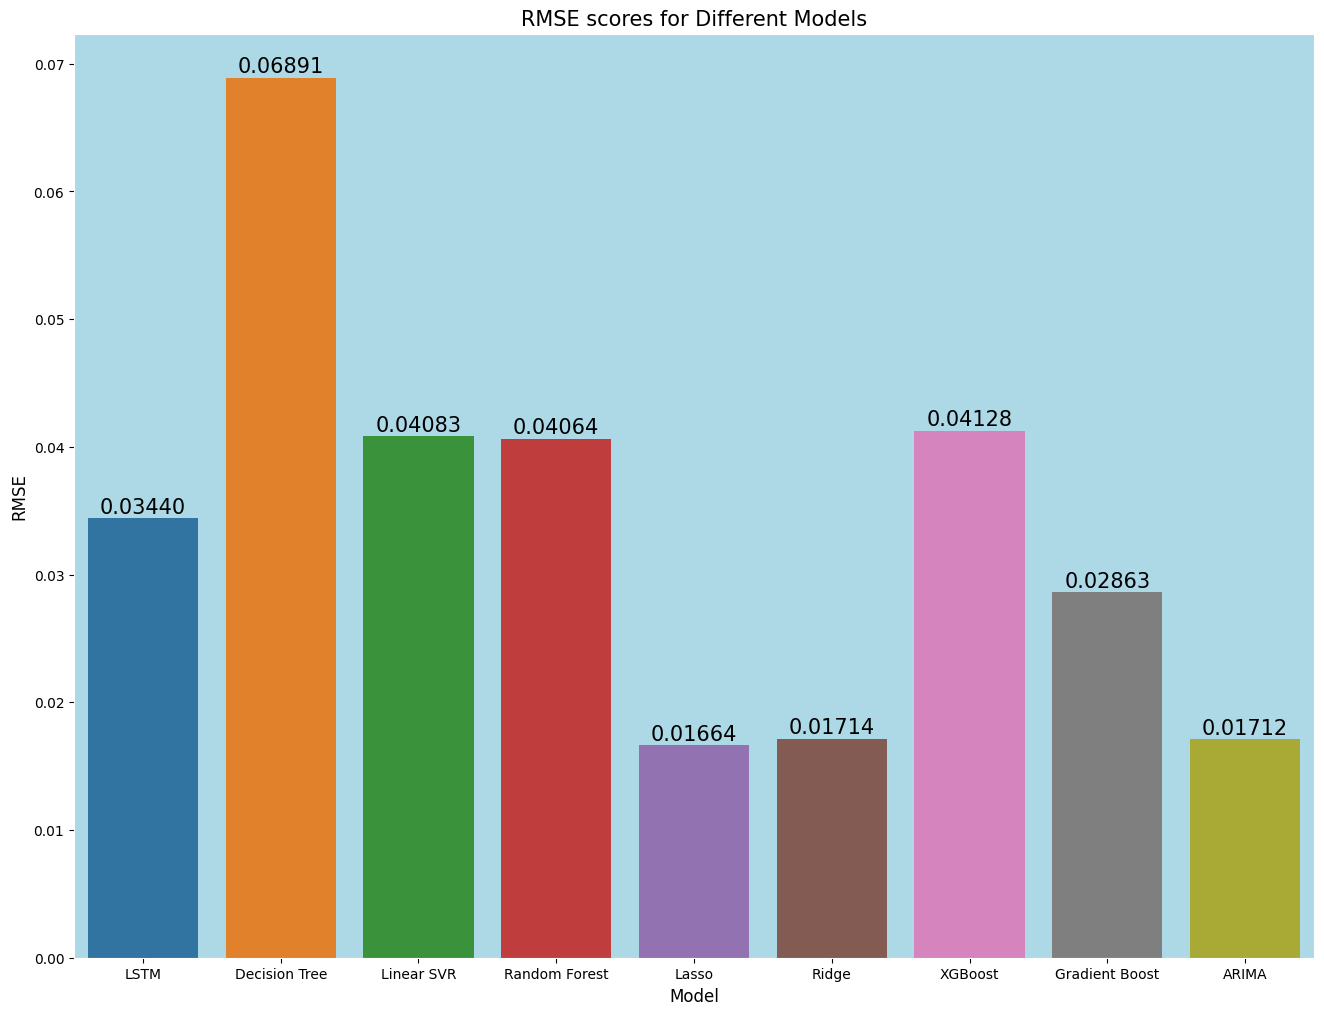

In [89]:
plots = sns.barplot( data=p_met, y="RMSE", x=p_met.index)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.5f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
    
plt.title('RMSE scores for Different Models', fontsize=15)
plt.xlabel('Model', fontsize=12)
plt.ylabel('RMSE', fontsize=12)

## Backtesting

In [90]:
from backtesting import Strategy
from backtesting.test import SMA
from backtesting.lib import crossover

c:\Users\ALIENWARE\anaconda3\Lib\site-packages\backtesting\test\__init__.py:8: FutureWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.

c:\Users\ALIENWARE\anaconda3\Lib\site-packages\backtesting\test\__init__.py:8: FutureWarning:

The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.



In [92]:
class SmaCross(Strategy):
    n1 = 20 # period of the first SMA
    n2 = 50 # period of the second SMA

    def init(self):
        close = self.data.Close # close price data
        self.sma1 = self.I(SMA, close, self.n1)
        self.sma2 = self.I(SMA, close, self.n2)
      
    def next(self):
      if crossover(self.sma1, self.sma2):
          self.buy()
      elif crossover(self.sma2, self.sma1):
          self.sell()

In [94]:
from backtesting.test import SMA

def std_3(arr, n):
    return pd.Series(arr).rolling(n).std() * 3

class MeanReversion(Strategy):
    roll = 50

    def init(self):
        self.he = self.data.Close

        self.he_mean = self.I(SMA, self.he, self.roll)
        self.he_std = self.I(std_3, self.he, self.roll)
        self.he_upper = self.he_mean + self.he_std
        self.he_lower = self.he_mean - self.he_std

        self.he_close = self.I(SMA, self.he, 1)

    def next(self):

        if self.he_close < self.he_lower:
            self.buy(
                tp = self.he_mean,
            )

        if self.he_close > self.he_upper:
            self.sell(
                tp = self.he_mean,
            )

from backtesting import Backtest

bt = Backtest(data, MeanReversion, cash=10000, commission=0.002)
stats = bt.run()
bt.plot()
stats

c:\Users\ALIENWARE\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'

c:\Users\ALIENWARE\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'



Start                     2014-01-22 00:00:00
End                       2024-01-19 00:00:00
Duration                   3649 days 00:00:00
Exposure Time [%]                   82.624398
Equity Final [$]                    3492.3312
Equity Peak [$]                    11570.7312
Return [%]                         -65.076688
Buy & Hold Return [%]               63.838204
Return (Ann.) [%]                  -10.092031
Volatility (Ann.) [%]                34.80958
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -74.927849
Avg. Drawdown [%]                  -10.340798
Max. Drawdown Duration     2591 days 00:00:00
Avg. Drawdown Duration      301 days 00:00:00
# Trades                                    3
Win Rate [%]                        66.666667
Best Trade [%]                       7.254707
Worst Trade [%]                    -75.777704
Avg. Trade [%]                    

Based on the provided performance metrics, the feasibility of the trading strategy appears to be low. Here's an analysis of the key metrics:

1. Return and Buy & Hold Return: The strategy experienced a negative return of -65.076688% over the duration of 3649 days. Comparatively, the buy and hold return was 63.838204%. The strategy significantly underperformed a simple buy and hold approach, resulting in a substantial loss.

2. Return (Ann.) and Volatility (Ann.): The annualized return was -10.092031%, and the annualized volatility was 34.80958%. The negative annualized return indicates that the strategy generated consistent losses on an annual basis. Additionally, the high annualized volatility suggests significant fluctuation and uncertainty in the strategy's performance.

3. Drawdown and Drawdown Duration: The maximum drawdown was -74.927849%, which is a substantial decline in equity. The drawdown duration was also considerable, lasting for 2591 days on average. These metrics indicate that the strategy experienced prolonged periods of significant losses, which could be challenging to recover from.

4. Sharpe Ratio and Sortino Ratio: Both the Sharpe ratio and Sortino ratio are reported as 0.0. These ratios measure risk-adjusted returns, with higher values indicating better performance. The fact that both ratios are 0.0 suggests that the strategy did not generate positive risk-adjusted returns and may have lacked effective risk management.

5. Win Rate and Profit Factor: The strategy had a win rate of 66.666667%, indicating that two out of three trades were profitable. However, the profit factor of 0.189084 is relatively low, suggesting that the gross profits were significantly outweighed by the gross losses.

6. Expectancy and SQN: The expectancy of -20.483124% represents the average expected return per trade, indicating a negative expectation. The SQN of -0.761524 is negative as well, indicating a poor overall quality of the trading system.

Considering these metrics, the feasibility of the trading strategy is questionable. The strategy exhibited a significant loss, high volatility, prolonged drawdowns, and a lack of positive risk-adjusted returns. It's crucial to thoroughly analyze the methodology, risk management approach, and market conditions to identify the weaknesses and potential improvements for this strategy.

In [95]:

stats = bt.optimize(
    roll=range(10, 60, 5),
    maximize="Equity Final [$]",
    constraint=lambda p: p.roll > 10,
)
stats

  0%|          | 0/9 [00:00<?, ?it/s]

Start                     2014-01-22 00:00:00
End                       2024-01-19 00:00:00
Duration                   3649 days 00:00:00
Exposure Time [%]                   13.242376
Equity Final [$]                   11597.8138
Equity Peak [$]                    11597.8138
Return [%]                          15.978138
Buy & Hold Return [%]               63.838204
Return (Ann.) [%]                    1.510261
Volatility (Ann.) [%]                4.390908
Sharpe Ratio                         0.343952
Sortino Ratio                         0.51081
Calmar Ratio                         0.235137
Max. Drawdown [%]                   -6.422887
Avg. Drawdown [%]                   -1.807051
Max. Drawdown Duration      197 days 00:00:00
Avg. Drawdown Duration       28 days 00:00:00
# Trades                                    6
Win Rate [%]                            100.0
Best Trade [%]                       5.941227
Worst Trade [%]                      1.174042
Avg. Trade [%]                    

Based on the provided performance metrics, the feasibility of the trading strategy appears to be relatively positive. Here's an analysis of the key metrics:

1. Return and Buy & Hold Return: The strategy achieved a return of 15.978138% over the duration of 3649 days. Comparatively, the buy and hold return was 63.838204%. The strategy's return, although lower than the buy and hold return, indicates a positive performance in generating profits.

2. Return (Ann.) and Volatility (Ann.): The annualized return was 1.510261%, and the annualized volatility was 4.390908%. While the annualized return is relatively low, it still indicates positive performance. The low volatility suggests that the strategy had relatively stable returns with limited fluctuations.

3. Drawdown and Drawdown Duration: The maximum drawdown was -6.422887%, which represents a moderate decline in equity. The maximum drawdown duration of 197 days and the average drawdown duration of 28 days indicate the strategy's ability to recover relatively quickly from drawdowns.

4. Sharpe Ratio and Sortino Ratio: The Sharpe ratio of 0.343952 and Sortino ratio of 0.51081 provide measures of risk-adjusted returns. Although not exceptionally high, the positive values of both ratios suggest that the strategy generated favorable risk-adjusted returns.

5. Win Rate and Profit Factor: The strategy had a 100% win rate, indicating that all trades were profitable. However, it's important to note that the number of trades was relatively small (only 6). The profit factor is reported as NaN, which suggests that there may have been no gross profits or gross losses during the trading period.

6. Expectancy and SQN: The expectancy of 3.466333% represents the average expected return per trade, indicating a positive expectation. The SQN of 3.692049 is above 2, which suggests a relatively favorable overall quality of the trading system.

Considering these metrics, the feasibility of the trading strategy appears to be promising. The strategy achieved positive returns, displayed a high win rate, and demonstrated favorable risk-adjusted returns. However, it's important to conduct a more comprehensive analysis, including assessing the methodology, trade execution, risk management techniques, and market conditions, to ensure a more robust evaluation of the strategy's feasibility.

In [96]:
stats['_strategy']

<Strategy MeanReversion(roll=20)>

In [97]:
bt.plot()

c:\Users\ALIENWARE\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%d %b'

c:\Users\ALIENWARE\anaconda3\Lib\site-packages\backtesting\_plotting.py:250: UserWarning:

DatetimeFormatter scales now only accept a single format. Using the first provided: '%m/%Y'



GridPlot(id='p2114', ...)

## Statistical Analysis

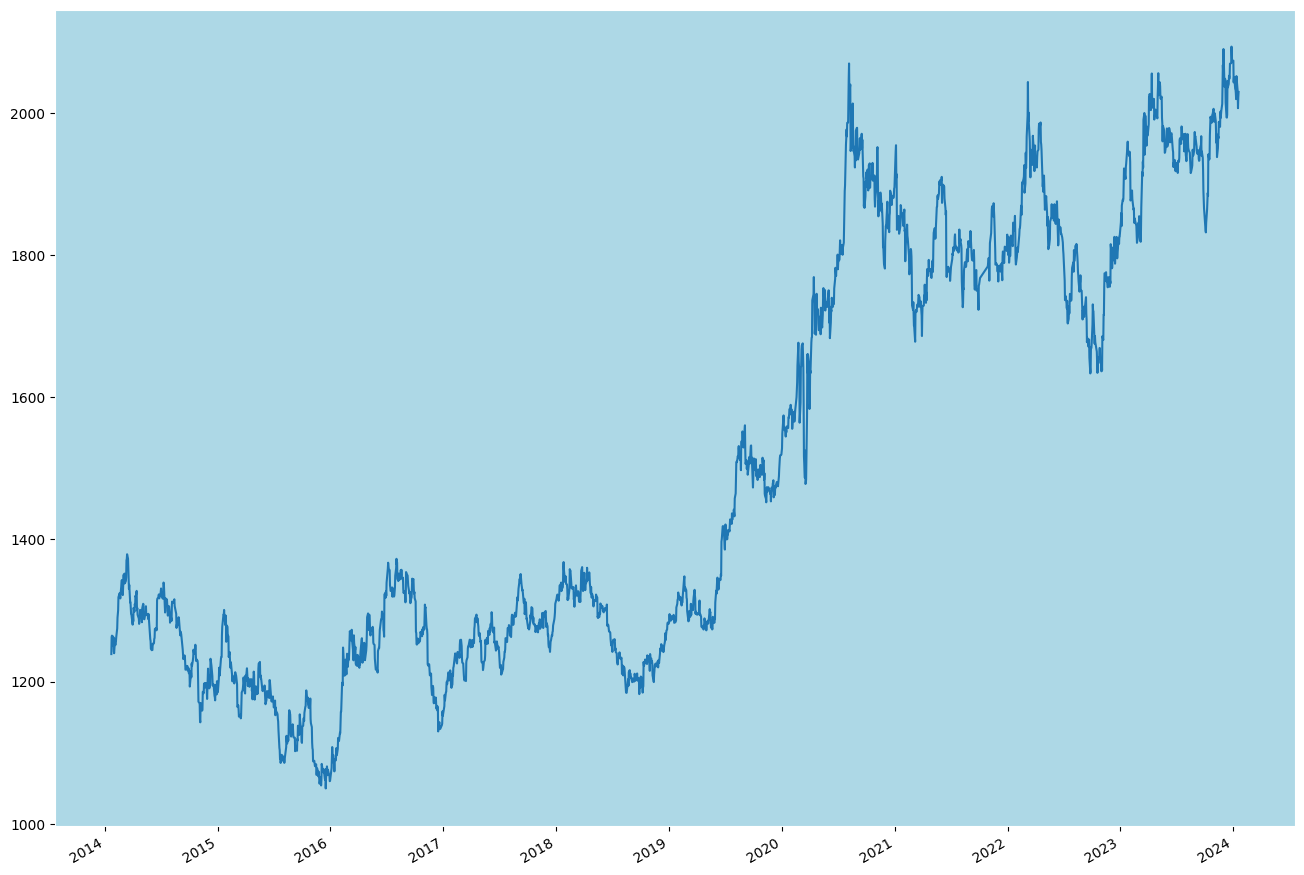

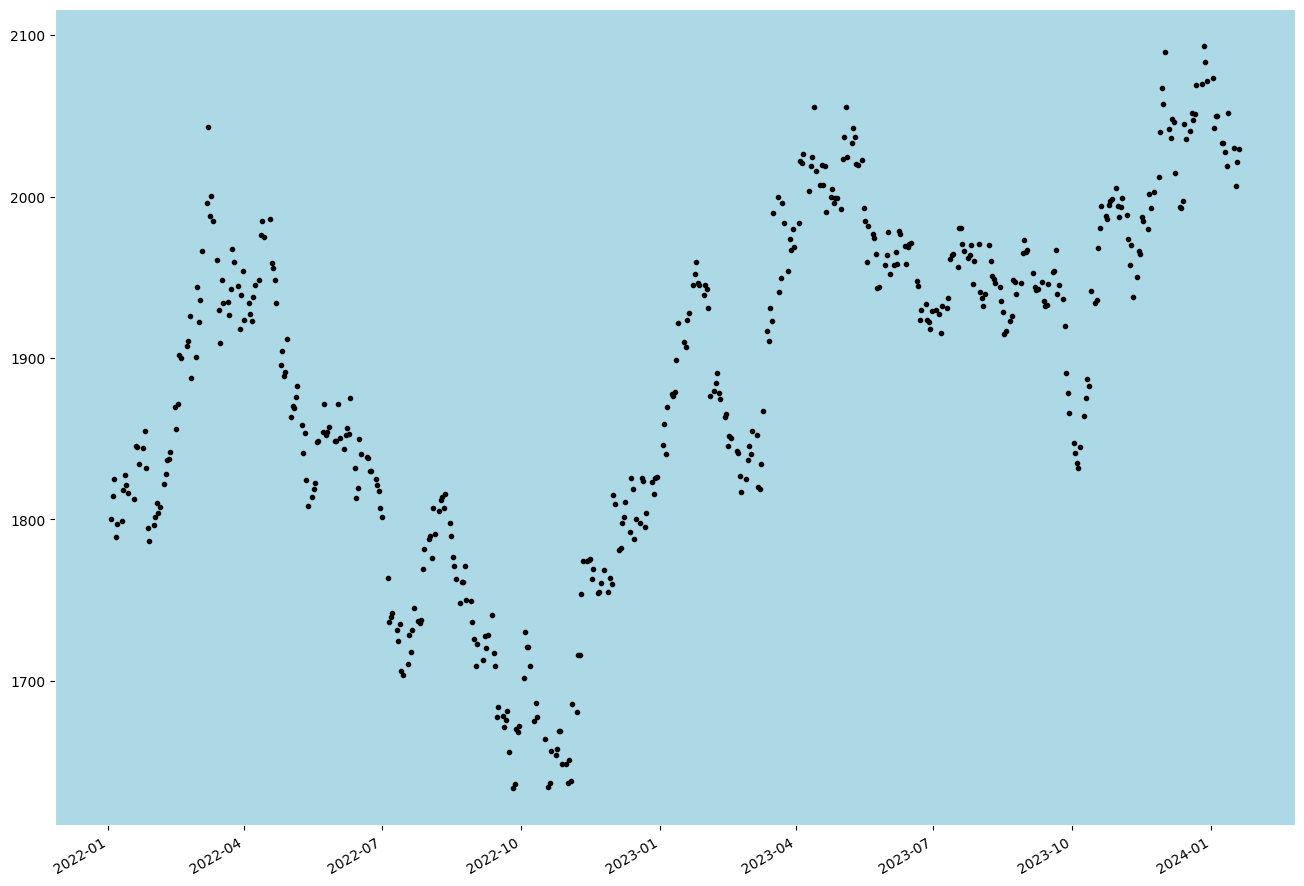

In [110]:
target_series = data['Close']
target_series.plot()
plt.show()
target_series[-test_size:].plot(style='k.')
plt.show()

In [107]:
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


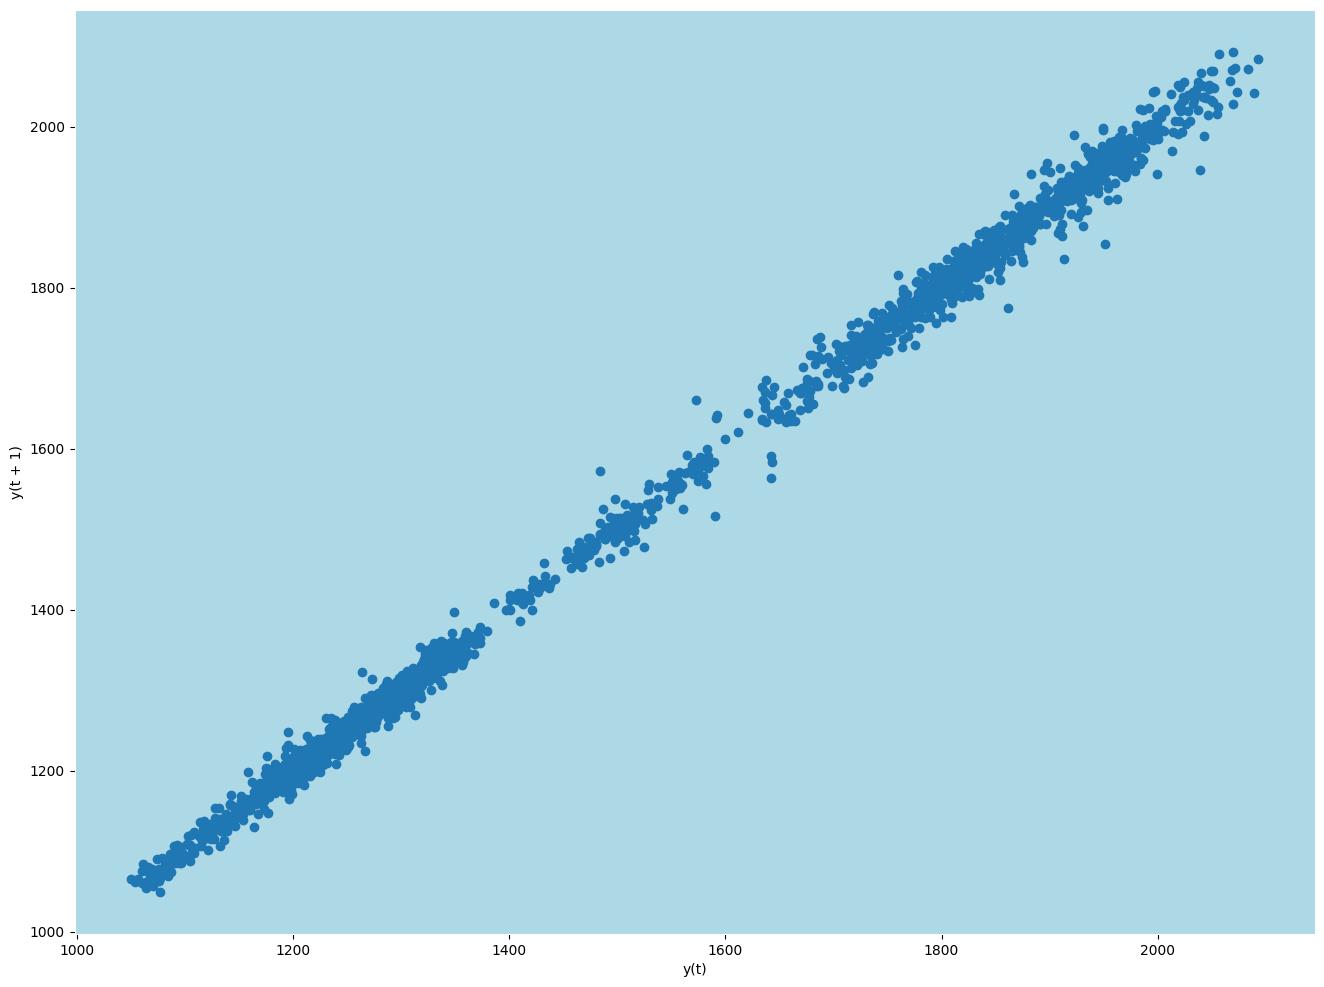

In [103]:
lag_plot(target_series)
plt.show()

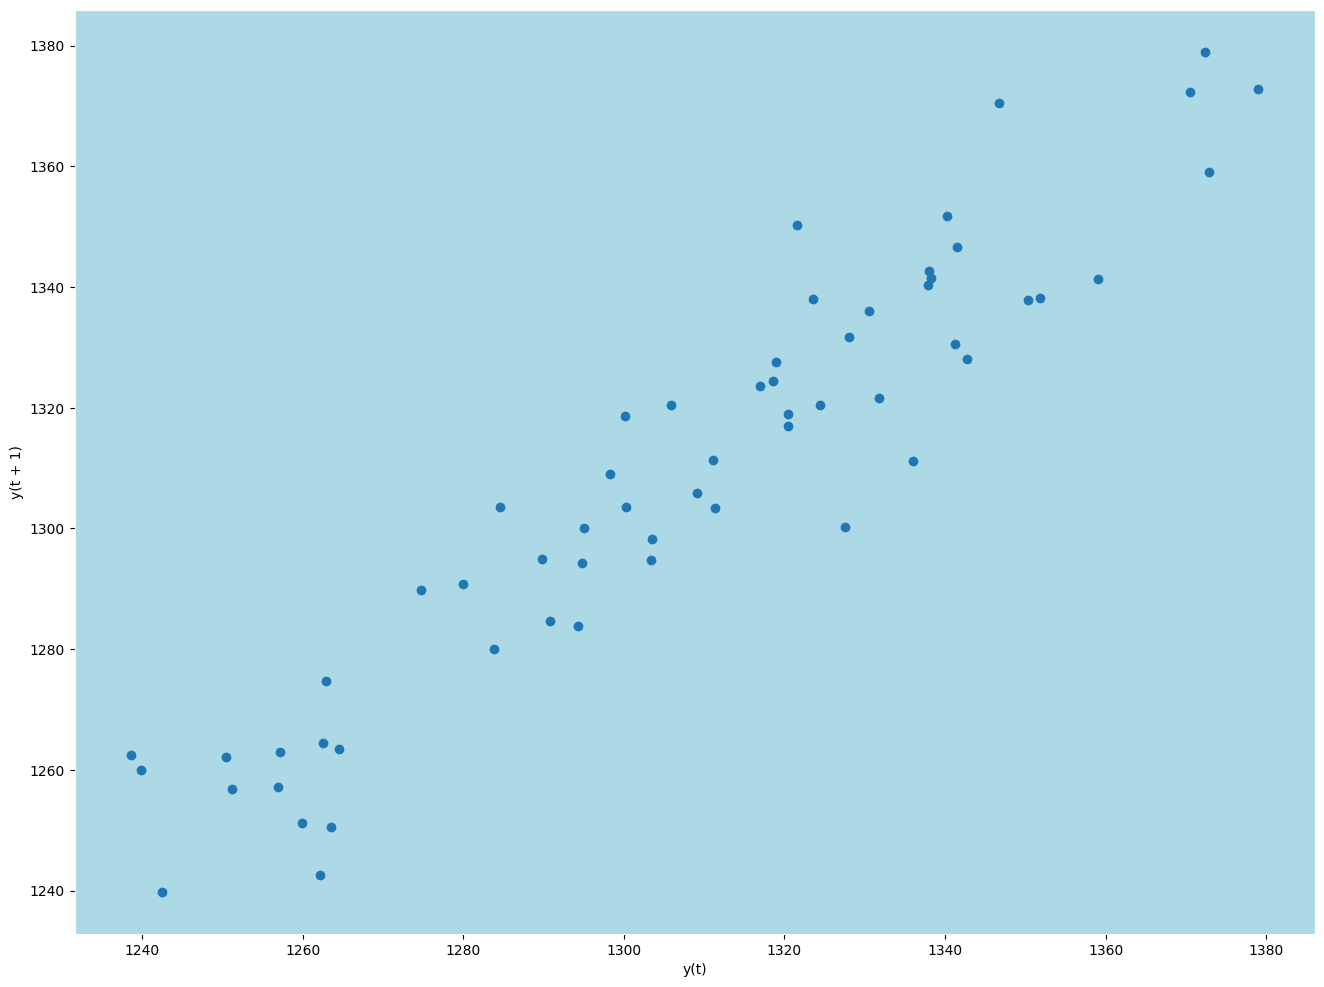

In [104]:
lag_plot(target_series[:60])
plt.show()

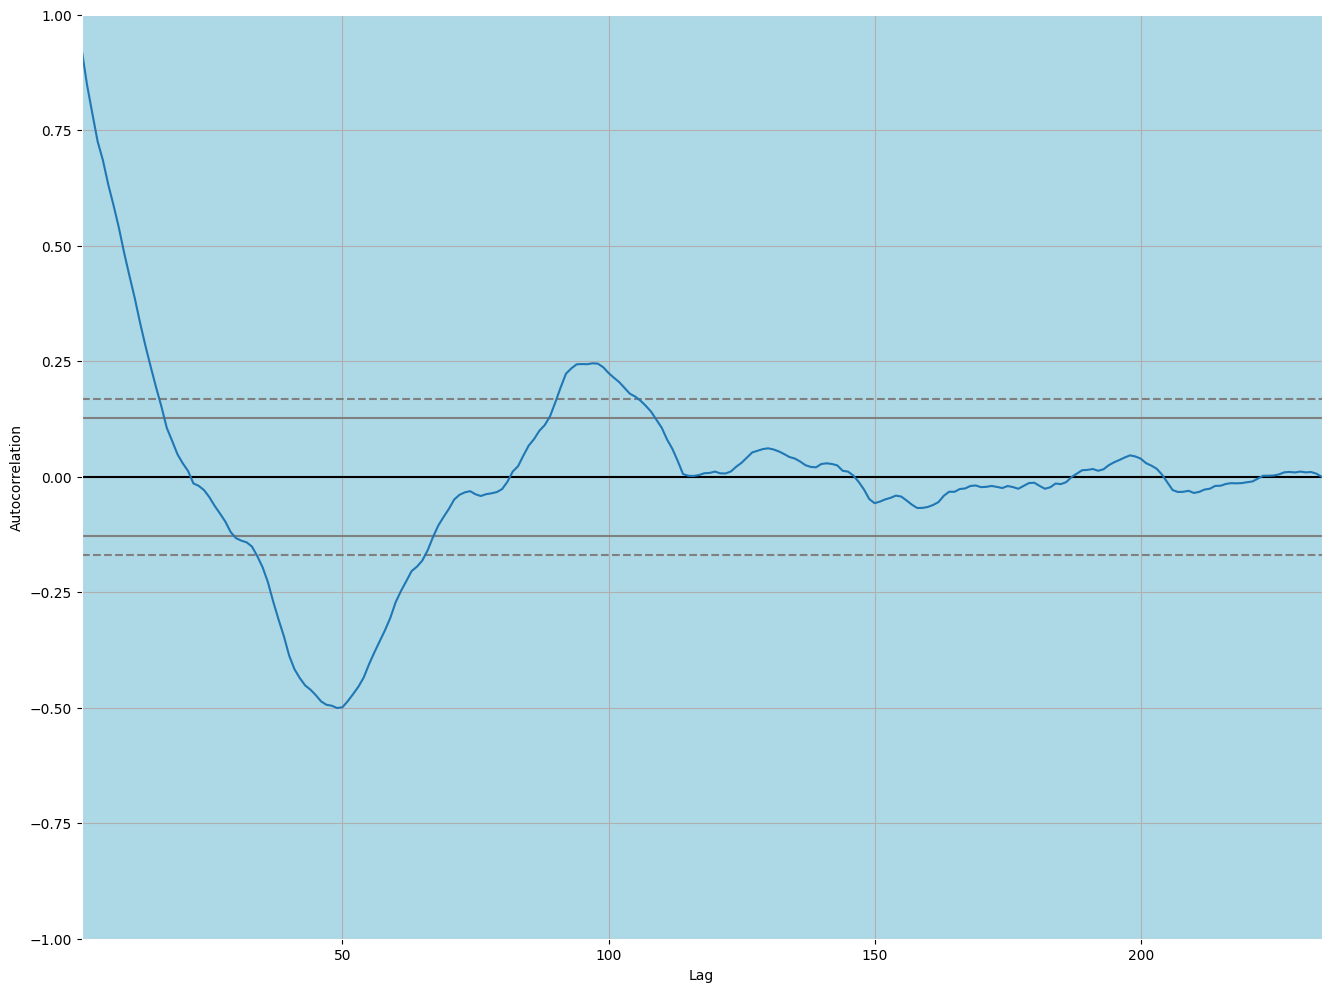

In [105]:
autocorrelation_plot(target_series['2021'])
plt.show()

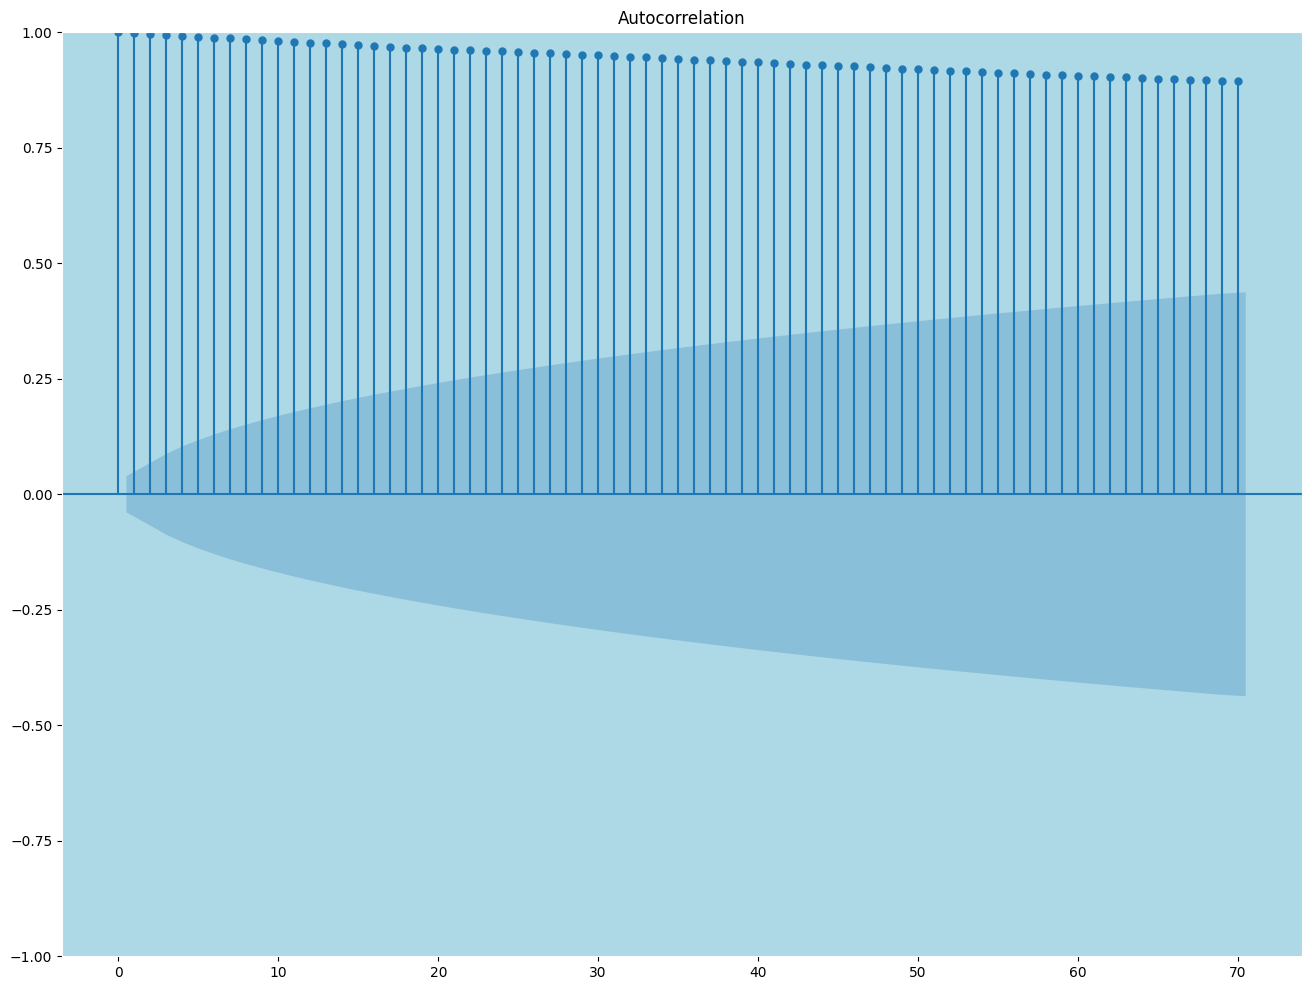

In [108]:
plot_acf(target_series, lags=70)
plt.show()

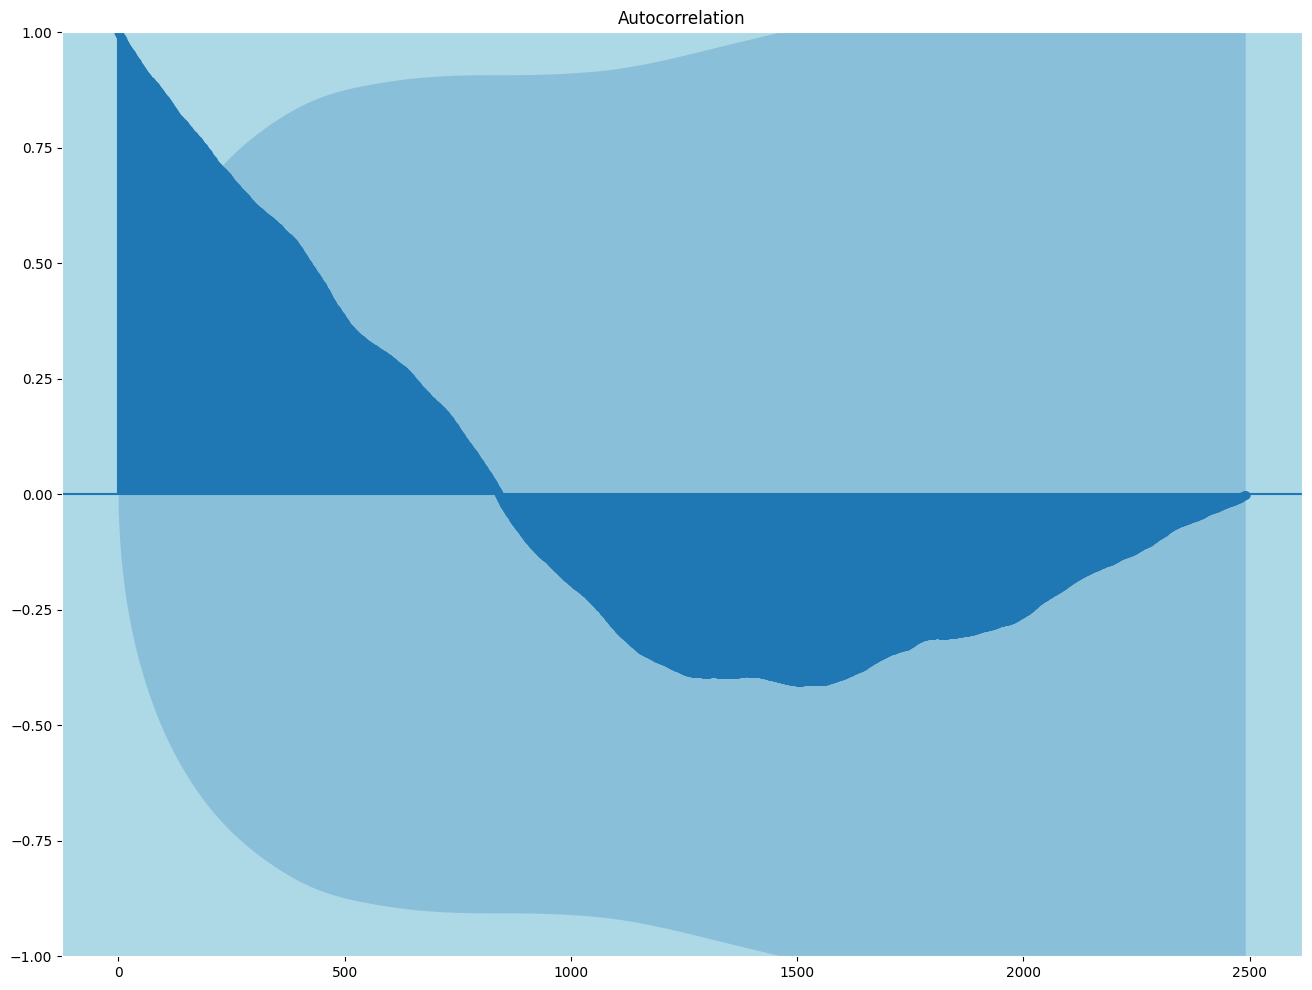

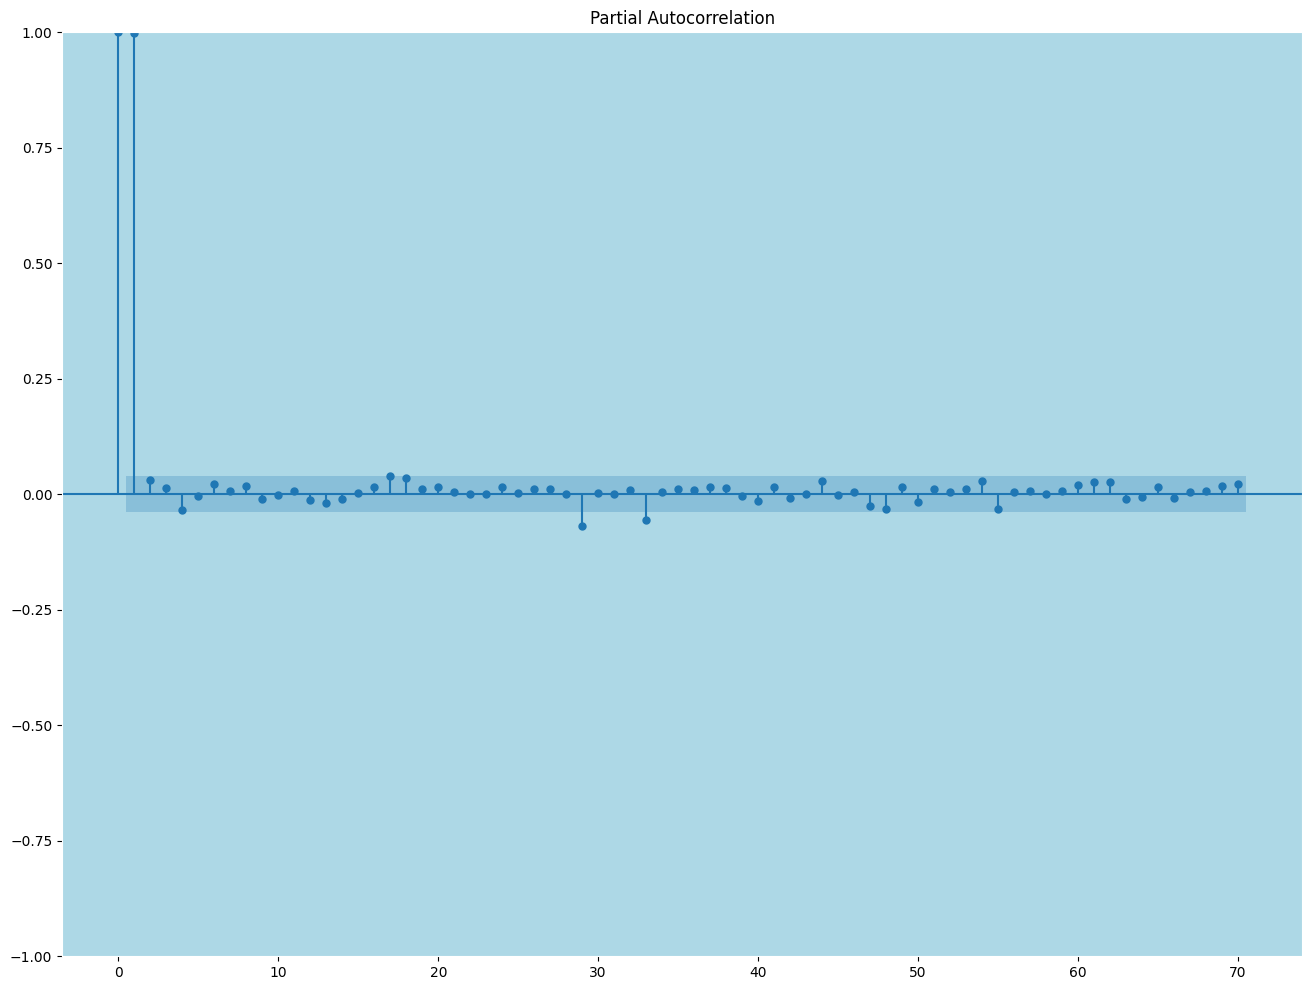

In [109]:
plot_acf(target_series, lags=target_series.shape[0]-1)
plt.show()

plot_pacf(target_series, lags=70)
plt.show()